# Southern Hydrate Ridge Seismicity Analysis

This notebook analyzes 200 Hz seismic data from Southern Hydrate Ridge (OO.HYSB stations) offshore Oregon to investigate seasonal variability in seismicity at hydrothermal vent fields.

## Objectives:
- Pull seismic data from IRIS for 2015
- Process data in batches to manage memory
- Calculate daily seismicity metrics
- Visualize temporal patterns to identify seasonal trends

## 1. Import Required Libraries

In [1]:
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print(f"ObsPy version: {obspy.__version__}")

ObsPy version: 1.4.2


## 2. Initialize IRIS Client and Define Station Parameters

In [2]:
# Initialize IRIS client
client = Client("IRIS")

# Station parameters for Southern Hydrate Ridge
network = "OO"
station = "HYS14"  # All HYS stations
location = "*"
channel = "HH*"  # High-sample-rate channels (typically 100-200 Hz)

# Time range for 2015
start_year = 2018
start_date = UTCDateTime(f"{start_year}-01-01")
end_date = UTCDateTime(f"{start_year + 1}-01-01")

print(f"Data collection period: {start_date} to {end_date}")
print(f"Network: {network}, Station: {station}")
print(f"Duration: {(end_date - start_date) / 86400:.0f} days")

Data collection period: 2018-01-01T00:00:00.000000Z to 2019-01-01T00:00:00.000000Z
Network: OO, Station: HYS14
Duration: 365 days


## 3. Check Available Stations and Metadata

In [3]:
# Get station inventory
try:
    inventory = client.get_stations(network=network, station=station, 
                                    location=location, channel=channel,
                                    starttime=start_date, endtime=end_date,
                                    level="channel")
    print(inventory)
    
    # Extract station details
    stations_found = []
    for net in inventory:
        for sta in net:
            stations_found.append(sta.code)
            print(f"\nStation: {sta.code}")
            print(f"  Latitude: {sta.latitude:.4f}, Longitude: {sta.longitude:.4f}")
            print(f"  Elevation: {sta.elevation:.1f} m")
            print(f"  Channels: {len(sta.channels)}")
            
except Exception as e:
    print(f"Error getting station inventory: {e}")

Inventory created at 2026-01-30T18:26:33.636200Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2018-01-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			OO
		Stations (1):
			OO.HYS14 (RSN Hydrate Summit 1-4)
		Channels (3):
			OO.HYS14..HHZ, OO.HYS14..HHN, OO.HYS14..HHE

Station: HYS14
  Latitude: 44.5692, Longitude: -125.1479
  Elevation: -775.0 m
  Channels: 3


In [4]:
def download_daily_data_in_chunks(client, network, station, location, channel, 
                                   start_date, end_date, chunk_hours=2):
    """
    Download seismic data day by day and store in hourly chunks.
    
    Parameters:
    -----------
    client : obspy.clients.fdsn.Client
        IRIS client object
    network : str
        Network code (e.g., 'OO')
    station : str
        Station code (e.g., 'HYS14')
    location : str
        Location code (e.g., '*')
    channel : str
        Channel code (e.g., 'HH*')
    start_date : UTCDateTime
        Start date for data collection
    end_date : UTCDateTime
        End date for data collection
    chunk_hours : int
        Size of chunks in hours (default: 2)
        
    Returns:
    --------
    dict : Dictionary with dates as keys, each containing list of chunk dictionaries
           Each chunk dict contains 'starttime', 'endtime', and channel ObsPy Trace objects
    """
    daily_data = {}
    current_date = start_date
    chunk_seconds = chunk_hours * 3600
    
    while current_date < end_date:
        day_start = current_date
        day_end = current_date + 86400  # One day in seconds
        
        print(f"Processing {day_start.date}...", end=" ")
        
        try:
            # Download one day of data
            st = client.get_waveforms(network=network, station=station,
                                     location=location, channel=channel,
                                     starttime=day_start, endtime=day_end)
            
            print(f"Downloaded {len(st)} traces", end=" ")
            
            # Filter to 200 Hz sampling rate
            st = st.select(sampling_rate=200.0)
            
            # Select three-component data
            st = st.select(channel='HH[ZNE]')
            
            if len(st) == 0:
                print("- No 3-component 200 Hz data available")
                current_date += 86400
                continue
            
            print(f"-> {len(st)} HH[ZNE] traces at 200 Hz", end=" ")
            
            # DEBUG: Filter to get only ONE trace per component (HHZ, HHN, HHE)
            components_to_keep = ['HHZ', 'HHN', 'HHE']
            st_filtered = obspy.Stream()
            
            for comp in components_to_keep:
                comp_traces = st.select(channel=comp)
                
                if len(comp_traces) == 0:
                    print(f"\n  WARNING: No {comp} trace found - skipping component")
                    continue
                    
                if len(comp_traces) > 1:
                    print(f"\n  WARNING: Multiple {comp} traces found ({len(comp_traces)}) - selecting first valid trace")
                    
                    # Select the first trace with valid data
                    valid_trace = None
                    for tr in comp_traces:
                        # Check for corrupted/missing data
                        if tr.data is None or len(tr.data) == 0:
                            print(f"    - Skipping {tr.id}: empty data")
                            continue
                        if np.all(np.isnan(tr.data)):
                            print(f"    - Skipping {tr.id}: all NaN values")
                            continue
                        if np.all(tr.data == 0):
                            print(f"    - Skipping {tr.id}: all zeros")
                            continue
                        
                        # Check for reasonable data range (seismic data in counts)
                        if np.max(np.abs(tr.data)) < 1e-10:
                            print(f"    - Skipping {tr.id}: suspiciously small amplitude")
                            continue
                            
                        valid_trace = tr
                        print(f"    - Selected {tr.id}: {len(tr.data)} samples, max amplitude: {np.max(np.abs(tr.data)):.2e}")
                        break
                    
                    if valid_trace is not None:
                        st_filtered.append(valid_trace)
                    else:
                        print(f"    - No valid {comp} trace found")
                else:
                    # Only one trace, but still validate it
                    tr = comp_traces[0]
                    
                    # Check for corrupted/missing data
                    if tr.data is None or len(tr.data) == 0:
                        print(f"\n  WARNING: {tr.id} has empty data - skipping")
                        continue
                    if np.all(np.isnan(tr.data)):
                        print(f"\n  WARNING: {tr.id} has all NaN values - skipping")
                        continue
                    if np.all(tr.data == 0):
                        print(f"\n  WARNING: {tr.id} has all zeros - skipping")
                        continue
                    if np.max(np.abs(tr.data)) < 1e-10:
                        print(f"\n  WARNING: {tr.id} has suspiciously small amplitude - skipping")
                        continue
                    
                    st_filtered.append(tr)
            
            # Check if we have all three components
            if len(st_filtered) != 3:
                print(f"\n  WARNING: Incomplete 3-component data (only {len(st_filtered)} components) - skipping day")
                current_date += 86400
                continue
            
            print(f"-> Using 3 components: {', '.join([tr.stats.channel for tr in st_filtered])}", end=" ")
            
            # Replace original stream with filtered one
            st = st_filtered
            
            # Merge and trim traces (handle any gaps)
            st.merge(fill_value=0)
            
            # Split day into chunks
            chunks = []
            chunk_start = day_start
            
            while chunk_start < day_end:
                chunk_end = min(chunk_start + chunk_seconds, day_end)
                
                # Trim stream to chunk window
                st_chunk = st.copy()
                st_chunk.trim(starttime=chunk_start, endtime=chunk_end, pad=True, fill_value=0)
                
                # Validate chunk data
                valid_chunk = True
                for tr in st_chunk:
                    # Check if chunk has valid data
                    if tr.data is None or len(tr.data) == 0:
                        print(f"\n  WARNING: Empty chunk data for {tr.stats.channel} - skipping chunk")
                        valid_chunk = False
                        break
                    
                    # Check for excessive NaN or zero values (>50% of data)
                    nan_ratio = np.sum(np.isnan(tr.data)) / len(tr.data)
                    zero_ratio = np.sum(tr.data == 0) / len(tr.data)
                    
                    if nan_ratio > 0.5:
                        print(f"\n  WARNING: Chunk has >50% NaN values for {tr.stats.channel} - skipping chunk")
                        valid_chunk = False
                        break
                    
                    if zero_ratio > 0.9:  # Allow some zeros from gaps, but not too many
                        print(f"\n  WARNING: Chunk has >90% zero values for {tr.stats.channel} - skipping chunk")
                        valid_chunk = False
                        break
                
                if not valid_chunk:
                    chunk_start = chunk_end
                    continue
                
                # Store chunk data
                chunk_dict = {
                    'starttime': chunk_start,
                    'endtime': chunk_end
                }
                
                # Store ObsPy Trace objects for each channel
                for tr in st_chunk:
                    channel_name = tr.stats.channel
                    chunk_dict[channel_name] = tr.copy()
                
                chunks.append(chunk_dict)
                chunk_start = chunk_end
            
            daily_data[day_start.date] = chunks
            print(f"-> {len(chunks)} valid chunks stored")
            
        except Exception as e:
            print(f"Error: {e}")
        
        current_date += 86400
    
    return daily_data

In [5]:
from scipy import signal

def process_and_extract_features(daily_data):
    """
    Process chunk data and extract seismic features.
    
    For each chunk:
    1. Linear detrend (using ObsPy)
    2. 5% Hanning window taper (using ObsPy)
    3. Highpass filter > 2 Hz (using ObsPy)
    4. Extract amplitude statistics (max, min, median, mean) for E, N, Z components
    5. Extract top 3 dominant frequencies for E, N, Z components using periodogram
    
    Parameters:
    -----------
    daily_data : dict
        Dictionary with dates as keys, each containing list of chunk dictionaries
        
    Returns:
    --------
    pd.DataFrame : DataFrame with extracted features for each chunk
    """
    features_list = []
    
    for date, chunks in daily_data.items():
        print(f"  Processing {len(chunks)} chunks for {date}...")
        
        for chunk_idx, chunk in enumerate(chunks):
            feature_dict = {
                'date': date,
                'chunk_index': chunk_idx,
                'starttime': chunk['starttime'],
                'endtime': chunk['endtime']
            }
            
            # Check that we have all three components
            required_components = ['HHE', 'HHN', 'HHZ']
            missing_components = [comp for comp in required_components if comp not in chunk]
            
            if missing_components:
                print(f"    WARNING: Chunk {chunk_idx} missing components: {missing_components} - skipping")
                continue
            
            valid_chunk = True
            
            # Process each component (E, N, Z)
            for component in required_components:
                try:
                    # Get the trace data
                    trace_data = chunk[component]
                    
                    # DEBUG: Validate trace data before processing
                    if trace_data is None:
                        print(f"    WARNING: Chunk {chunk_idx} - {component} is None - skipping chunk")
                        valid_chunk = False
                        break
                    
                    # If it's already a Trace object, use it directly
                    if isinstance(trace_data, obspy.Trace):
                        tr = trace_data.copy()
                    else:
                        # Create an ObsPy Trace object from the chunk data
                        tr = obspy.Trace(data=trace_data.copy())
                        tr.stats.sampling_rate = 200.0
                        tr.stats.starttime = chunk['starttime']
                    
                    # Additional data validation
                    if len(tr.data) == 0:
                        print(f"    WARNING: Chunk {chunk_idx} - {component} has no data - skipping chunk")
                        valid_chunk = False
                        break
                    
                    # Check for NaN values
                    nan_count = np.sum(np.isnan(tr.data))
                    if nan_count > 0:
                        print(f"    WARNING: Chunk {chunk_idx} - {component} has {nan_count} NaN values - replacing with zeros")
                        tr.data = np.nan_to_num(tr.data, nan=0.0)
                    
                    # Check for infinite values
                    inf_count = np.sum(np.isinf(tr.data))
                    if inf_count > 0:
                        print(f"    WARNING: Chunk {chunk_idx} - {component} has {inf_count} infinite values - replacing with zeros")
                        tr.data = np.nan_to_num(tr.data, posinf=0.0, neginf=0.0)
                    
                    # Check if data is all zeros or near-zero
                    max_amplitude = np.max(np.abs(tr.data))
                    if max_amplitude < 1e-10:
                        print(f"    WARNING: Chunk {chunk_idx} - {component} has suspiciously small amplitude ({max_amplitude:.2e}) - skipping chunk")
                        valid_chunk = False
                        break
                    
                    # 1. Linear detrend using ObsPy
                    tr.detrend(type='linear')
                    
                    # 2. 5% Hanning taper using ObsPy
                    tr.taper(type='hann', max_percentage=0.05)
                    
                    # 3. Highpass filter > 2 Hz using ObsPy
                    tr.filter(type='highpass', freq=2.0)
                    
                    # Get processed data
                    data = tr.data
                    
                    # Final check after processing
                    if np.any(np.isnan(data)) or np.any(np.isinf(data)):
                        print(f"    WARNING: Chunk {chunk_idx} - {component} has NaN/Inf after processing - skipping chunk")
                        valid_chunk = False
                        break
                    
                    # 4. Extract amplitude statistics
                    comp_short = component[-1]  # E, N, or Z
                    feature_dict[f'{comp_short}_max'] = np.max(data)
                    feature_dict[f'{comp_short}_min'] = np.min(data)
                    feature_dict[f'{comp_short}_median'] = np.median(data)
                    feature_dict[f'{comp_short}_mean'] = np.mean(data)
                    
                    # 5. Extract top 3 dominant frequencies using periodogram
                    try:
                        freqs, psd = signal.periodogram(data, fs=tr.stats.sampling_rate)
                        
                        # Check for valid PSD
                        if np.any(np.isnan(psd)) or np.any(np.isinf(psd)):
                            print(f"    WARNING: Chunk {chunk_idx} - {component} has invalid PSD - using zeros")
                            feature_dict[f'{comp_short}_freq1'] = 0.0
                            feature_dict[f'{comp_short}_freq2'] = 0.0
                            feature_dict[f'{comp_short}_freq3'] = 0.0
                            feature_dict[f'{comp_short}_power1'] = 0.0
                            feature_dict[f'{comp_short}_power2'] = 0.0
                            feature_dict[f'{comp_short}_power3'] = 0.0
                        else:
                            # Get indices of top 3 peaks
                            top_3_indices = np.argsort(psd)[-3:][::-1]
                            top_3_freqs = freqs[top_3_indices]
                            top_3_power = psd[top_3_indices]
                            
                            feature_dict[f'{comp_short}_freq1'] = top_3_freqs[0]
                            feature_dict[f'{comp_short}_freq2'] = top_3_freqs[1]
                            feature_dict[f'{comp_short}_freq3'] = top_3_freqs[2]
                            feature_dict[f'{comp_short}_power1'] = top_3_power[0]
                            feature_dict[f'{comp_short}_power2'] = top_3_power[1]
                            feature_dict[f'{comp_short}_power3'] = top_3_power[2]
                    
                    except Exception as e:
                        print(f"    WARNING: Chunk {chunk_idx} - {component} PSD computation failed: {e} - using zeros")
                        feature_dict[f'{comp_short}_freq1'] = 0.0
                        feature_dict[f'{comp_short}_freq2'] = 0.0
                        feature_dict[f'{comp_short}_freq3'] = 0.0
                        feature_dict[f'{comp_short}_power1'] = 0.0
                        feature_dict[f'{comp_short}_power2'] = 0.0
                        feature_dict[f'{comp_short}_power3'] = 0.0
                
                except Exception as e:
                    print(f"    ERROR: Chunk {chunk_idx} - {component} processing failed: {e} - skipping chunk")
                    valid_chunk = False
                    break
            
            # Only add features if all components were processed successfully
            if valid_chunk:
                features_list.append(feature_dict)
            else:
                print(f"    Skipped chunk {chunk_idx} due to data quality issues")
    
    # Convert to DataFrame
    df_features = pd.DataFrame(features_list)
    
    print(f"  Successfully extracted features from {len(df_features)} chunks")
    
    return df_features

In [6]:
def process_seismic_data_daily(client, network, station, location, channel,
                                start_date, num_days, chunk_hours=2):
    """
    Process seismic data day by day, extracting features for each chunk.
    
    This function downloads data one day at a time, processes it in chunks,
    extracts features, and compiles everything into a single DataFrame.
    
    Parameters:
    -----------
    client : obspy.clients.fdsn.Client
        IRIS client object
    network : str
        Network code (e.g., 'OO')
    station : str
        Station code (e.g., 'HYS14')
    location : str
        Location code (e.g., '*')
    channel : str
        Channel code (e.g., 'HH*')
    start_date : UTCDateTime
        Start date for data collection
    num_days : int
        Number of days to process
    chunk_hours : int
        Size of chunks in hours (default: 2)
        
    Returns:
    --------
    pd.DataFrame : DataFrame containing all extracted features plus station metadata
    """
    
    # Get station metadata
    try:
        inv = client.get_stations(network=network, station=station,
                                  location=location, channel=channel,
                                  starttime=start_date, 
                                  endtime=start_date + num_days * 86400,
                                  level="station")
        
        # Extract station information
        station_lat = inv[0][0].latitude
        station_lon = inv[0][0].longitude
        station_elev = inv[0][0].elevation
        station_name = inv[0][0].code
        
        print(f"Station metadata:")
        print(f"  Name: {station_name}")
        print(f"  Latitude: {station_lat:.4f}")
        print(f"  Longitude: {station_lon:.4f}")
        print(f"  Elevation: {station_elev:.1f} m\n")
        
    except Exception as e:
        print(f"Warning: Could not retrieve station metadata: {e}")
        station_name = station
        station_lat = None
        station_lon = None
        station_elev = None
    
    all_features = []
    
    # Process data day by day
    for day_offset in range(num_days):
        current_start = start_date + day_offset * 86400
        current_end = current_start + 86400
        
        print(f"\n{'='*60}")
        print(f"Day {day_offset + 1}/{num_days}: {current_start.date}")
        print(f"{'='*60}")
        
        # Download one day of data in chunks
        daily_data = download_daily_data_in_chunks(
            client, network, station, location, channel,
            current_start, current_end, chunk_hours=chunk_hours
        )
        
        # Process and extract features if data was downloaded
        if len(daily_data) > 0:
            df_daily_features = process_and_extract_features(daily_data)
            
            # Add station metadata to each row
            df_daily_features['station_name'] = station_name
            df_daily_features['station_lat'] = station_lat
            df_daily_features['station_lon'] = station_lon
            df_daily_features['station_elev'] = station_elev
            
            all_features.append(df_daily_features)
            print(f"  Extracted features from {len(df_daily_features)} chunks")
        else:
            print(f"  No data available for this day")
    
    # Combine all daily features into one DataFrame
    if len(all_features) > 0:
        df_all_features = pd.concat(all_features, ignore_index=True)
        
        # Reorder columns to put metadata first
        metadata_cols = ['station_name', 'station_lat', 'station_lon', 'station_elev',
                        'date', 'chunk_index', 'starttime', 'endtime']
        other_cols = [col for col in df_all_features.columns if col not in metadata_cols]
        df_all_features = df_all_features[metadata_cols + other_cols]
        
        print(f"\n{'='*60}")
        print(f"Processing complete!")
        print(f"Total chunks processed: {len(df_all_features)}")
        print(f"Total features per chunk: {len(other_cols)}")
        print(f"{'='*60}\n")
        
        return df_all_features
    else:
        print("\nNo data was successfully processed.")
        return pd.DataFrame()

In [7]:
def plot_feature_distributions(df, figsize=(15, 4), bins=30):
    """
    Plot histograms and box plots for each numerical, non-NaN valued feature in a DataFrame.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame containing features to visualize
    figsize : tuple
        Figure size for each feature plot (width, height)
    bins : int
        Number of bins for histograms
    """
    # Get numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Filter out columns that are entirely NaN
    valid_cols = [col for col in numerical_cols if df[col].notna().any()]
    
    if len(valid_cols) == 0:
        print("No valid numerical columns with non-NaN values found.")
        return
    
    print(f"Plotting distributions for {len(valid_cols)} numerical features...\n")
    
    # Plot each feature
    for col in valid_cols:
        # Remove NaN values for plotting
        data = df[col].dropna()
        
        if len(data) == 0:
            continue
        
        # Create figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Histogram
        axes[0].hist(data, bins=bins, color='steelblue', alpha=0.7, edgecolor='black')
        axes[0].set_xlabel('Value', fontweight='bold')
        axes[0].set_ylabel('Frequency', fontweight='bold')
        axes[0].set_title(f'Histogram: {col}', fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        
        # Add statistics text
        stats_text = f'Mean: {data.mean():.2e}\nMedian: {data.median():.2e}\nStd: {data.std():.2e}'
        axes[0].text(0.02, 0.98, stats_text, transform=axes[0].transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                    fontsize=9)
        
        # Box plot
        bp = axes[1].boxplot(data, vert=True, patch_artist=True)
        bp['boxes'][0].set_facecolor('lightblue')
        axes[1].set_ylabel('Value', fontweight='bold')
        axes[1].set_title(f'Box Plot: {col}', fontweight='bold')
        axes[1].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
        
    print(f"\nPlotting complete for {len(valid_cols)} features.")

In [8]:
def plot_correlation_matrix(df, figsize=(12, 10), cmap='coolwarm', annot=True, fmt='.2f'):
    """
    Plot a correlation matrix heatmap for all numerical, non-NaN valued features in a DataFrame.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame containing features to analyze
    figsize : tuple
        Figure size (width, height)
    cmap : str
        Colormap for the heatmap (default: 'coolwarm')
    annot : bool
        Whether to annotate cells with correlation values (default: True)
    fmt : str
        String formatting for annotations (default: '.2f')
    """
    # Get numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Filter out columns that are entirely NaN
    valid_cols = [col for col in numerical_cols if df[col].notna().any()]
    
    if len(valid_cols) == 0:
        print("No valid numerical columns with non-NaN values found.")
        return
    
    if len(valid_cols) < 2:
        print("Need at least 2 numerical features to compute correlations.")
        return
    
    # Select only valid columns and compute correlation matrix
    df_valid = df[valid_cols]
    corr_matrix = df_valid.corr()
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap
    im = ax.imshow(corr_matrix, cmap=cmap, aspect='auto', vmin=-1, vmax=1)
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(valid_cols)))
    ax.set_yticks(np.arange(len(valid_cols)))
    ax.set_xticklabels(valid_cols, rotation=45, ha='right')
    ax.set_yticklabels(valid_cols)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20, fontweight='bold')
    
    # Annotate cells with correlation values
    if annot:
        for i in range(len(valid_cols)):
            for j in range(len(valid_cols)):
                text = ax.text(j, i, format(corr_matrix.iloc[i, j], fmt),
                             ha='center', va='center', 
                             color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black',
                             fontsize=8)
    
    # Set title
    ax.set_title('Feature Correlation Matrix', fontweight='bold', fontsize=14, pad=20)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nCorrelation matrix computed for {len(valid_cols)} numerical features.")
    
    # Print highly correlated pairs (|correlation| > 0.8, excluding diagonal)
    print("\nHighly correlated feature pairs (|r| > 0.8):")
    high_corr_pairs = []
    for i in range(len(valid_cols)):
        for j in range(i+1, len(valid_cols)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.8:
                high_corr_pairs.append((valid_cols[i], valid_cols[j], corr_val))
    
    if len(high_corr_pairs) > 0:
        for feat1, feat2, corr_val in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"  {feat1} <-> {feat2}: {corr_val:.3f}")
    else:
        print("  None found")

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def perform_pca_analysis(df, n_components=None, scale_data=True, plot_results=True, figsize=(15, 5)):
    """
    Perform PCA (Principal Component Analysis) on numerical features of a DataFrame.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame containing features to analyze
    n_components : int or None
        Number of principal components to compute (default: None = all components)
    scale_data : bool
        Whether to standardize features before PCA (default: True, recommended)
    plot_results : bool
        Whether to plot variance explained and component loadings (default: True)
    figsize : tuple
        Figure size for plots (width, height)
        
    Returns:
    --------
    dict : Dictionary containing:
        - 'pca_model': fitted PCA model (sklearn.decomposition.PCA)
        - 'transformed_data': DataFrame with transformed data (PC scores)
        - 'explained_variance_ratio': array of variance explained by each PC
        - 'cumulative_variance': array of cumulative variance explained
        - 'loadings': DataFrame with feature loadings for each PC
        - 'feature_names': list of original feature names used
        - 'scaler': fitted StandardScaler (if scale_data=True), else None
    """
    
    # Get numerical columns only (exclude metadata columns)
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Filter out columns that are entirely NaN
    valid_cols = [col for col in numerical_cols if df[col].notna().any()]
    
    if len(valid_cols) == 0:
        print("No valid numerical columns found for PCA.")
        return None
    
    print(f"Performing PCA on {len(valid_cols)} numerical features...")
    print(f"Features: {valid_cols}\n")
    
    # Extract feature matrix
    X = df[valid_cols].values
    
    # Handle any remaining NaN values (replace with column mean)
    col_means = np.nanmean(X, axis=0)
    for i in range(X.shape[1]):
        X[np.isnan(X[:, i]), i] = col_means[i]
    
    # Standardize features if requested
    scaler = None
    if scale_data:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        print("Data standardized (mean=0, std=1)")
    else:
        X_scaled = X
        print("Data not standardized (using raw values)")
    
    # Perform PCA
    if n_components is None:
        n_components = min(X_scaled.shape[0], X_scaled.shape[1])
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"\nPCA computed with {pca.n_components_} components")
    print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")
    
    # Create DataFrame with transformed data
    pc_columns = [f'PC{i+1}' for i in range(pca.n_components_)]
    df_pca = pd.DataFrame(X_pca, columns=pc_columns, index=df.index)
    
    # Create loadings DataFrame
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=pc_columns,
        index=valid_cols
    )
    
    # Calculate cumulative variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Print variance explained
    print("\nVariance explained by each component:")
    for i in range(min(5, pca.n_components_)):
        print(f"  PC{i+1}: {pca.explained_variance_ratio_[i]:.4f} ({cumulative_variance[i]:.4f} cumulative)")
    
    # Plot results
    if plot_results:
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        
        # 1. Scree plot (variance explained)
        axes[0].bar(range(1, len(pca.explained_variance_ratio_) + 1), 
                    pca.explained_variance_ratio_, 
                    alpha=0.7, color='steelblue', edgecolor='black')
        axes[0].set_xlabel('Principal Component', fontweight='bold')
        axes[0].set_ylabel('Variance Explained Ratio', fontweight='bold')
        axes[0].set_title('Scree Plot', fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        
        # 2. Cumulative variance plot
        axes[1].plot(range(1, len(cumulative_variance) + 1), 
                     cumulative_variance, 
                     marker='o', linewidth=2, color='darkred')
        axes[1].axhline(y=0.95, color='green', linestyle='--', label='95% threshold')
        axes[1].set_xlabel('Number of Components', fontweight='bold')
        axes[1].set_ylabel('Cumulative Variance Explained', fontweight='bold')
        axes[1].set_title('Cumulative Variance Explained', fontweight='bold')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # 3. PC1 vs PC2 scatter plot
        if pca.n_components_ >= 2:
            scatter = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], 
                                     c=range(len(X_pca)), cmap='viridis', 
                                     alpha=0.6, edgecolor='black')
            axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontweight='bold')
            axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontweight='bold')
            axes[2].set_title('PC1 vs PC2', fontweight='bold')
            axes[2].grid(True, alpha=0.3)
            plt.colorbar(scatter, ax=axes[2], label='Sample Index')
        else:
            axes[2].text(0.5, 0.5, 'Not enough components\nfor 2D plot', 
                        ha='center', va='center', transform=axes[2].transAxes)
            axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Plot feature loadings for first 2 PCs
        if pca.n_components_ >= 2:
            fig, ax = plt.subplots(figsize=(10, 6))
            
            x = np.arange(len(valid_cols))
            width = 0.35
            
            ax.bar(x - width/2, loadings['PC1'], width, label='PC1', alpha=0.8)
            ax.bar(x + width/2, loadings['PC2'], width, label='PC2', alpha=0.8)
            
            ax.set_xlabel('Features', fontweight='bold')
            ax.set_ylabel('Loading', fontweight='bold')
            ax.set_title('Feature Loadings on PC1 and PC2', fontweight='bold')
            ax.set_xticks(x)
            ax.set_xticklabels(valid_cols, rotation=45, ha='right')
            ax.legend()
            ax.grid(True, alpha=0.3, axis='y')
            
            plt.tight_layout()
            plt.show()
    
    # Return results dictionary
    results = {
        'pca_model': pca,
        'transformed_data': df_pca,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'cumulative_variance': cumulative_variance,
        'loadings': loadings,
        'feature_names': valid_cols,
        'scaler': scaler
    }
    
    return results

Station metadata:
  Name: HYS14
  Latitude: 44.5692
  Longitude: -125.1479
  Elevation: -775.0 m


Day 1/365: 2018-01-01
Processing 2018-01-01... Downloaded 3 traces - No 3-component 200 Hz data available
  No data available for this day

Day 2/365: 2018-01-02
Processing 2018-01-02... Downloaded 3 traces -> 3 HH[ZNE] traces at 200 Hz -> Using 3 components: HHZ, HHN, HHE -> 12 valid chunks stored
  Processing 12 chunks for 2018-01-02...
  Successfully extracted features from 12 chunks
  Extracted features from 12 chunks

Day 3/365: 2018-01-03
Processing 2018-01-03... Downloaded 3 traces -> 2 HH[ZNE] traces at 200 Hz 

  No data available for this day

Day 4/365: 2018-01-04
Processing 2018-01-04... Downloaded 6 traces -> 5 HH[ZNE] traces at 200 Hz 
    - Selected OO.HYS14..HHN: 8467490 samples, max amplitude: 9.97e+04

    - Selected OO.HYS14..HHE: 8467742 samples, max amplitude: 1.43e+05
-> Using 3 components: HHZ, HHN, HHE 










-> 1 valid chunks stored
  Processing 1 chunks for 2

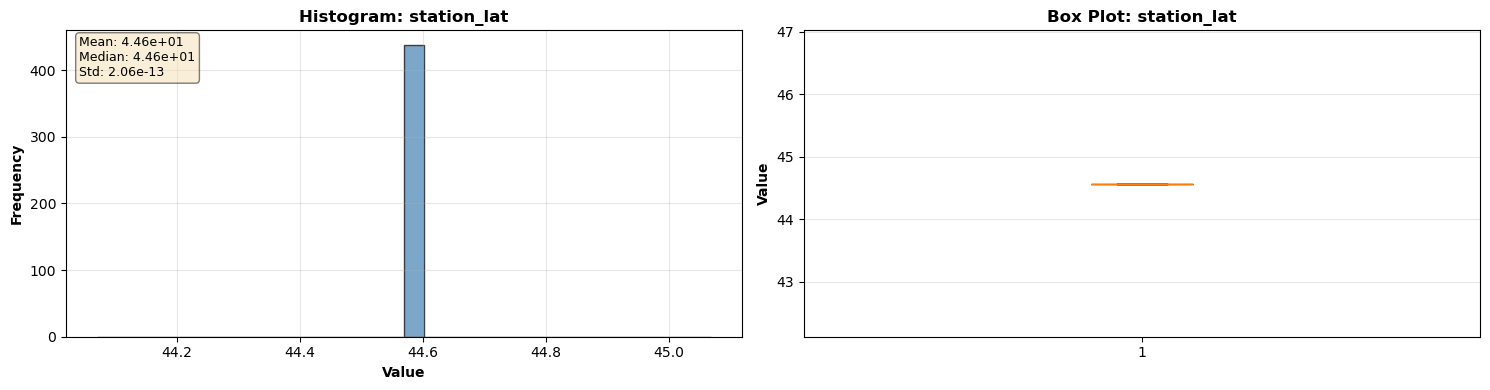

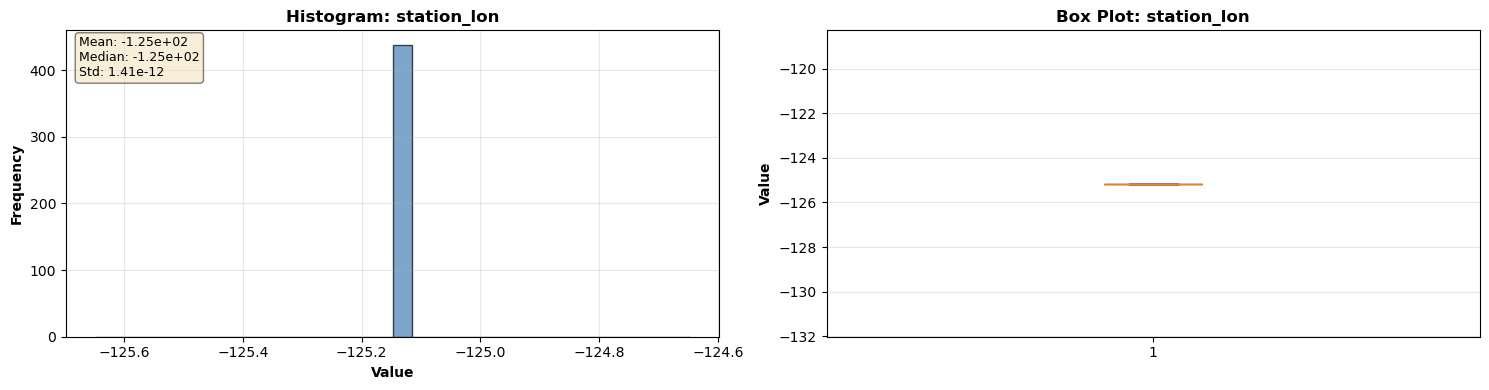

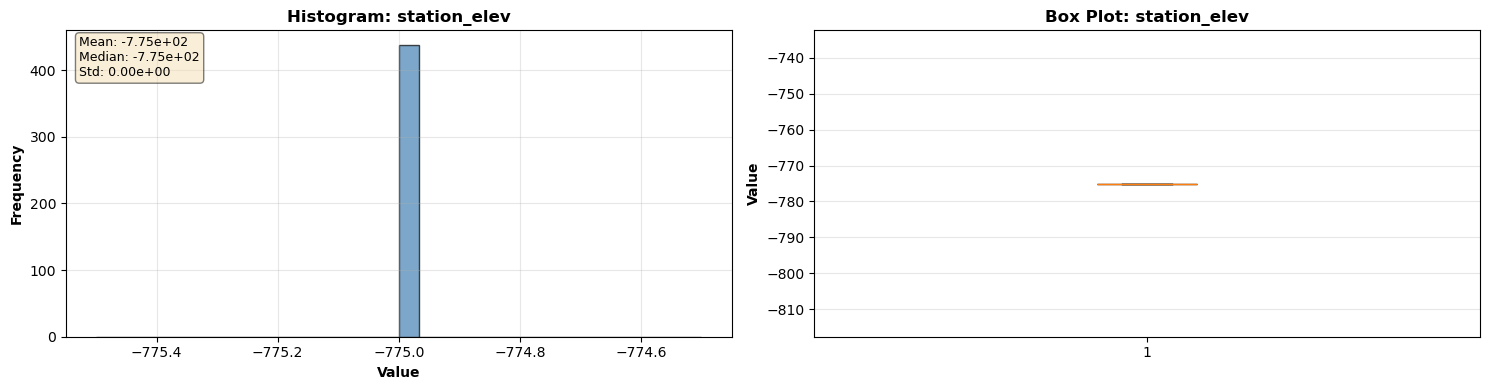

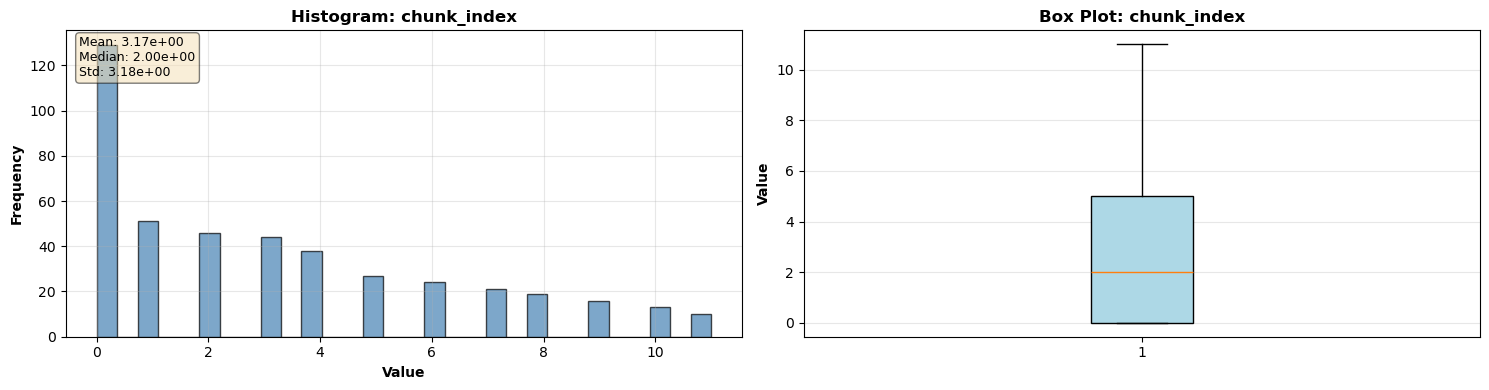

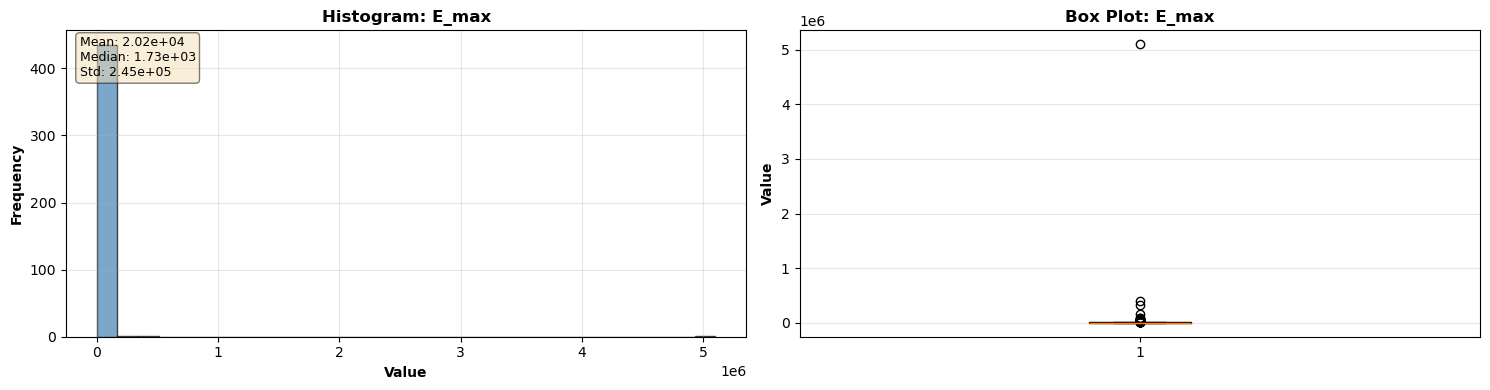

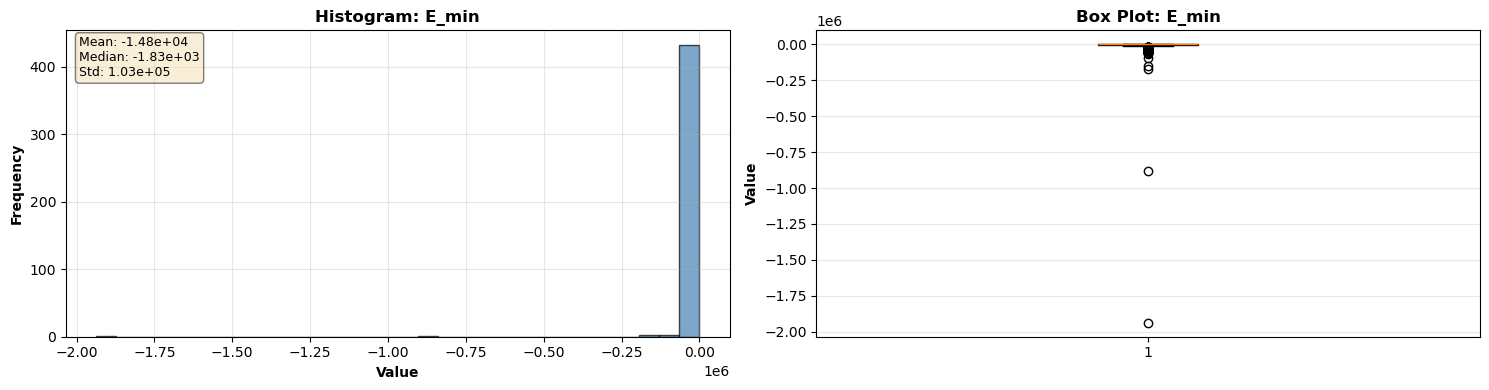

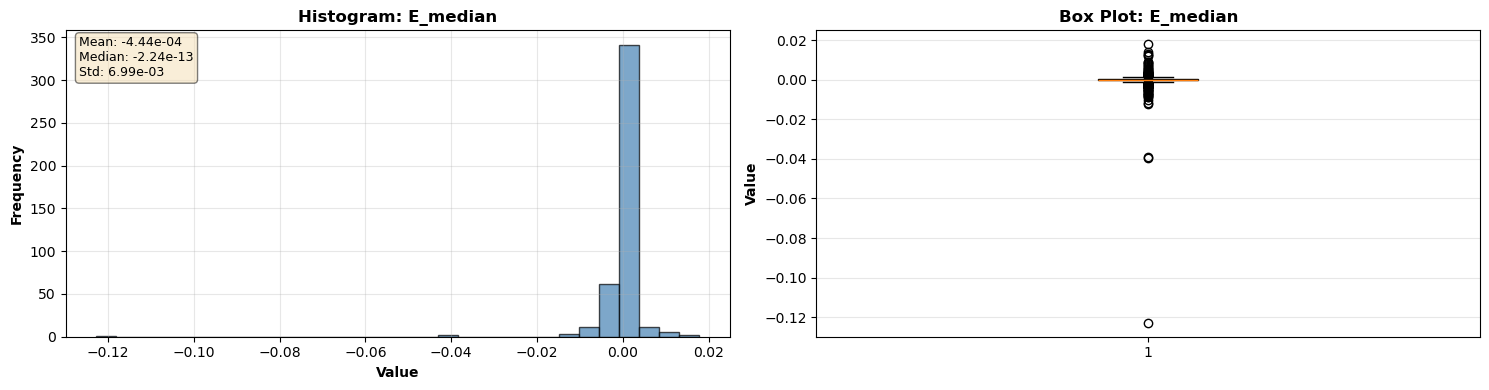

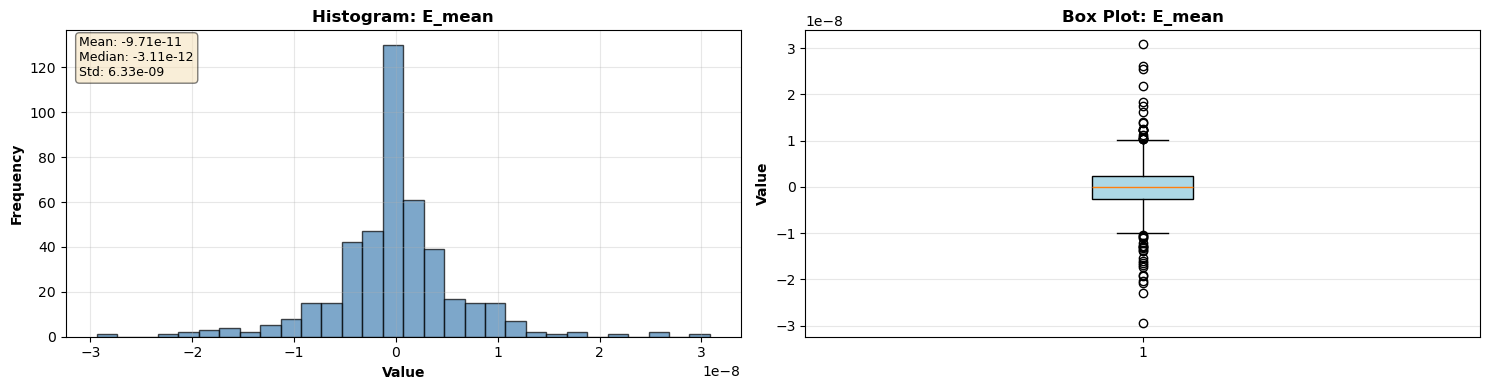

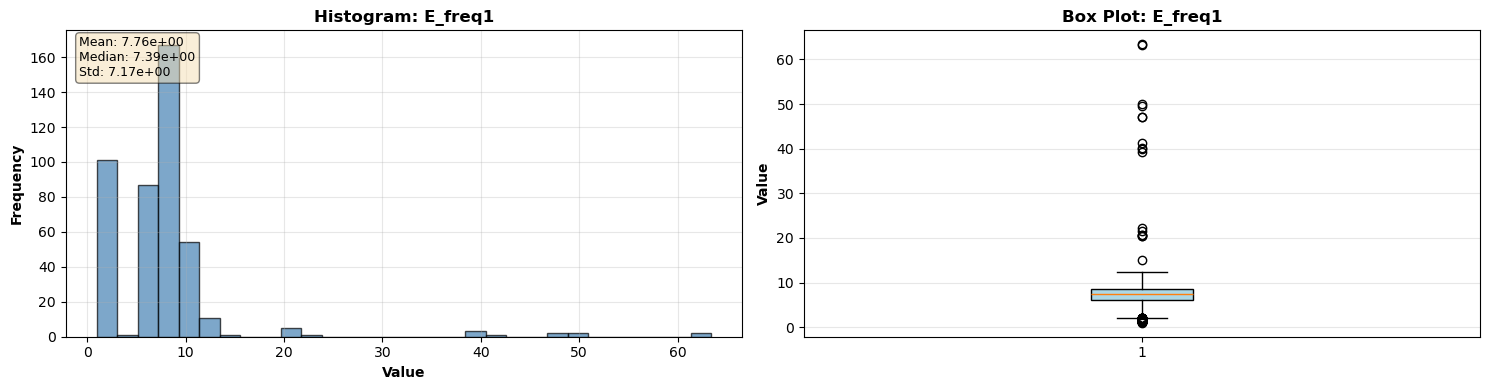

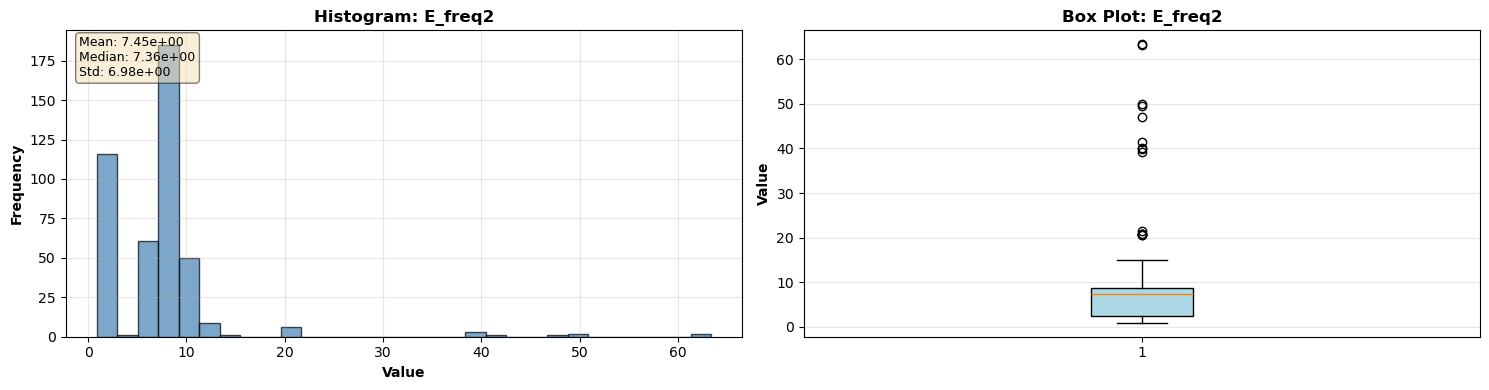

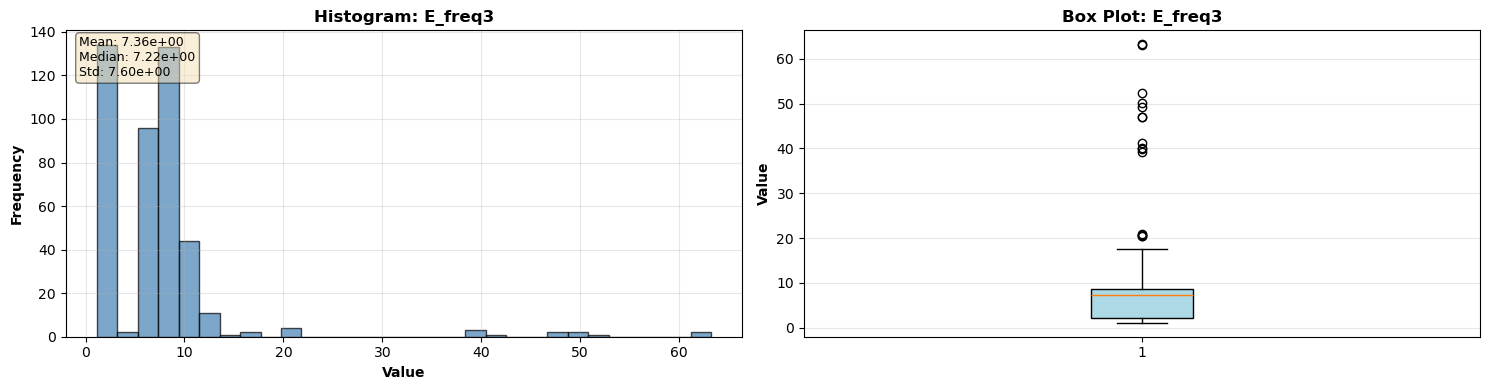

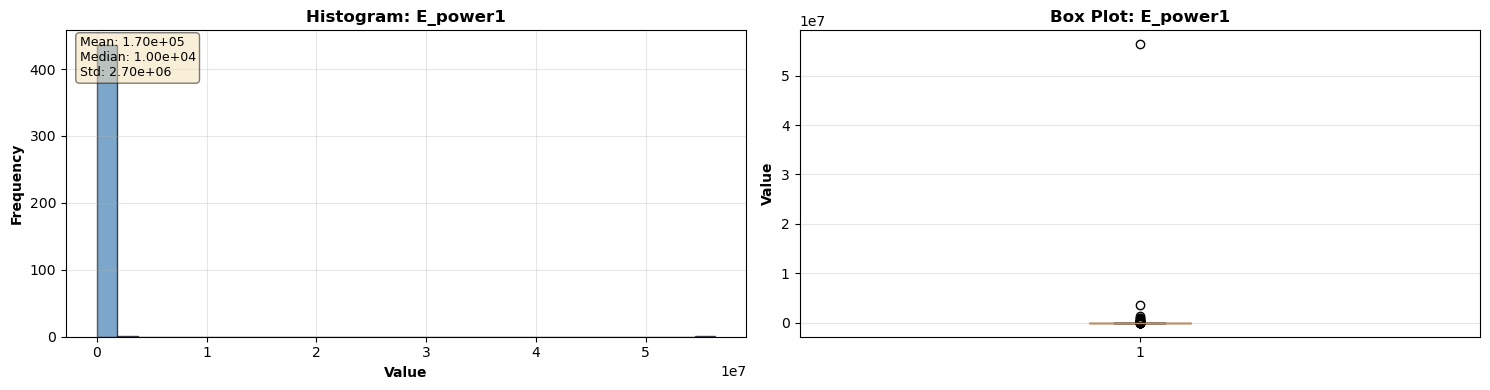

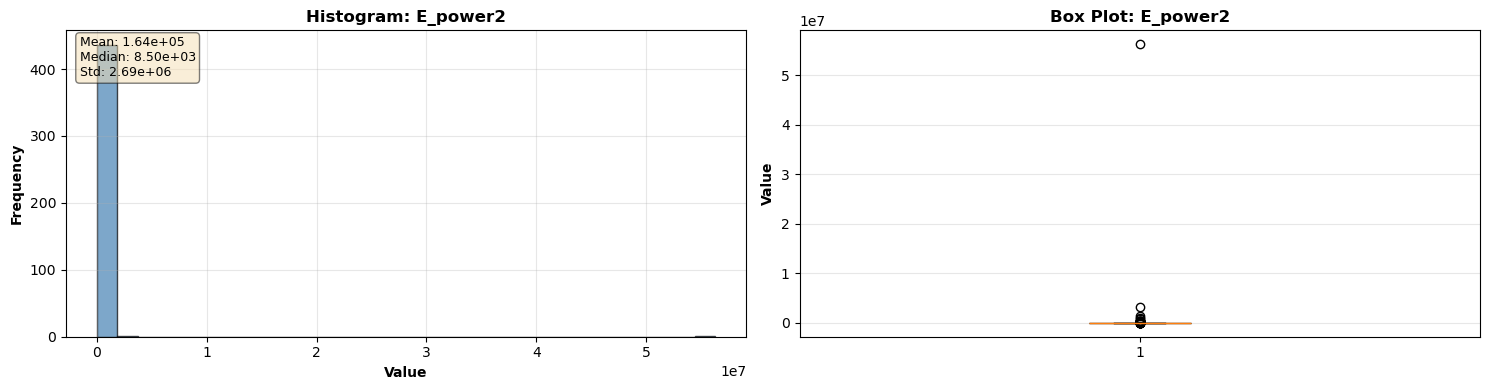

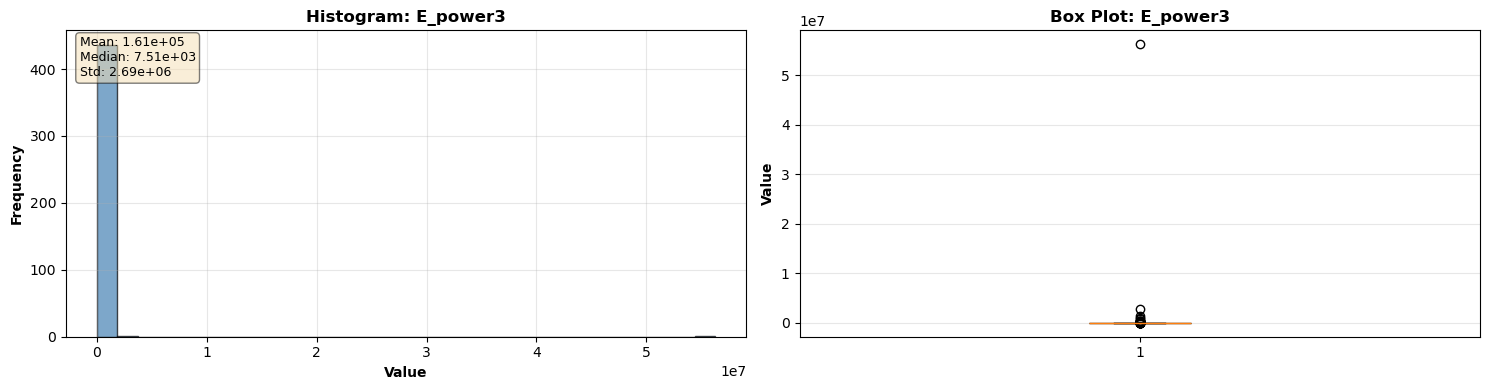

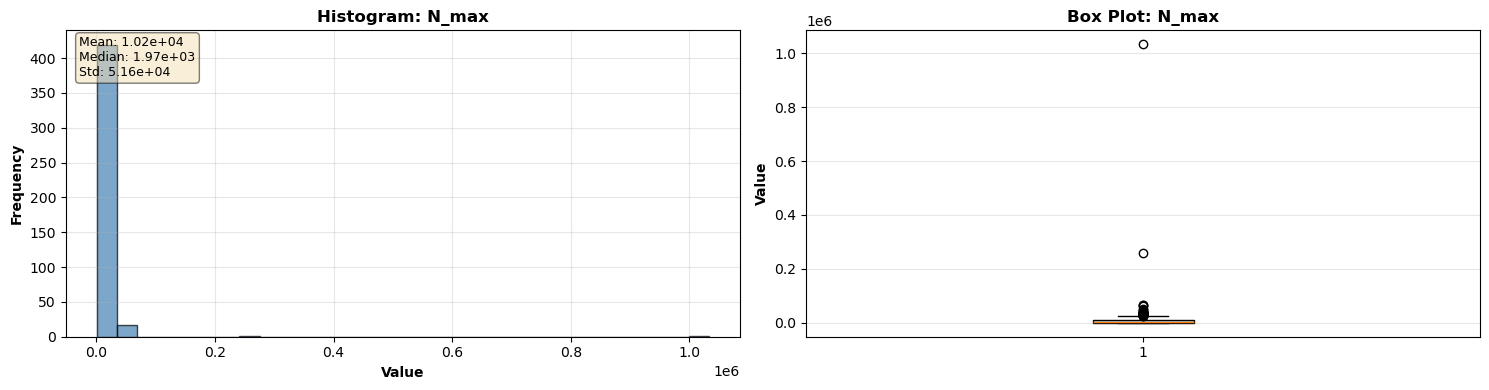

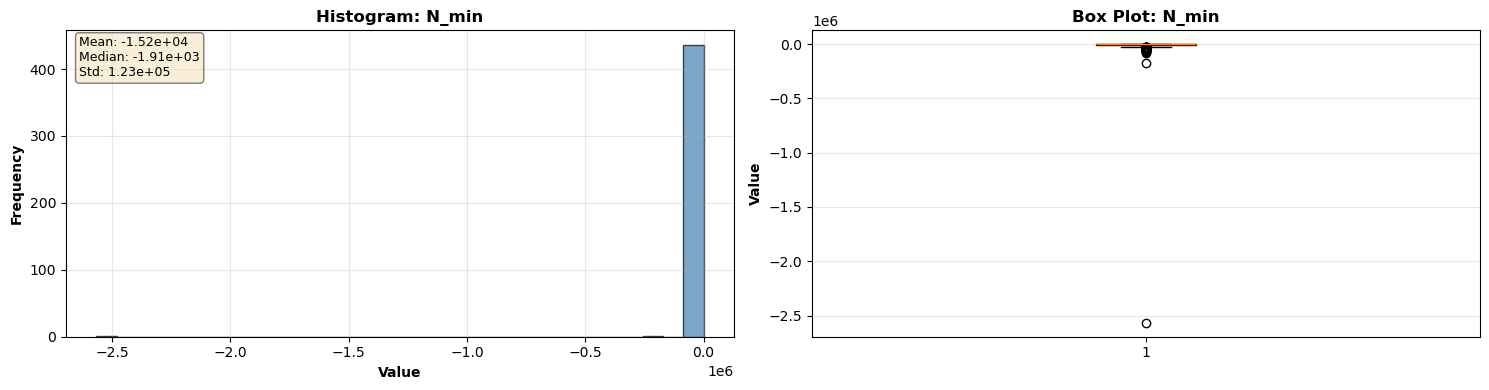

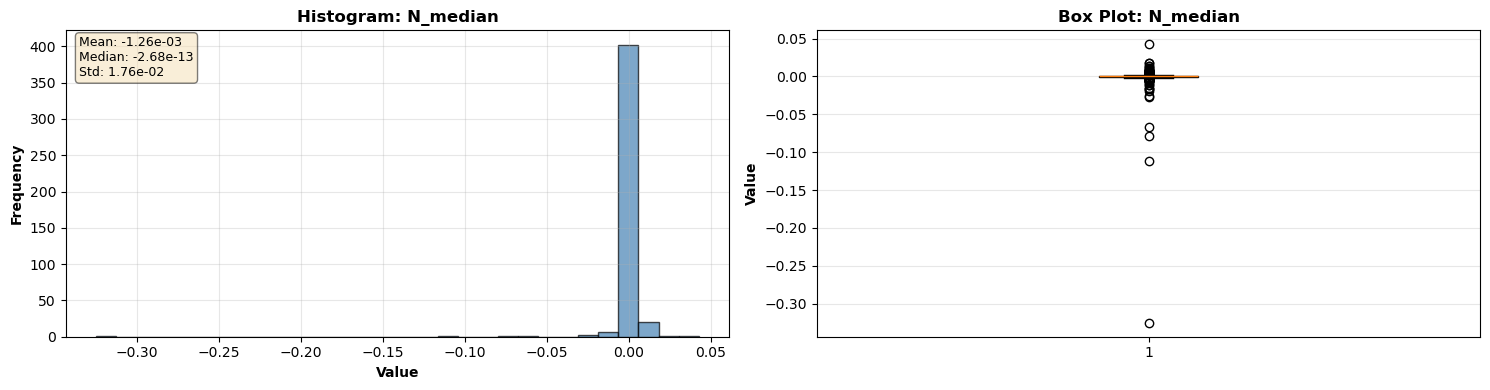

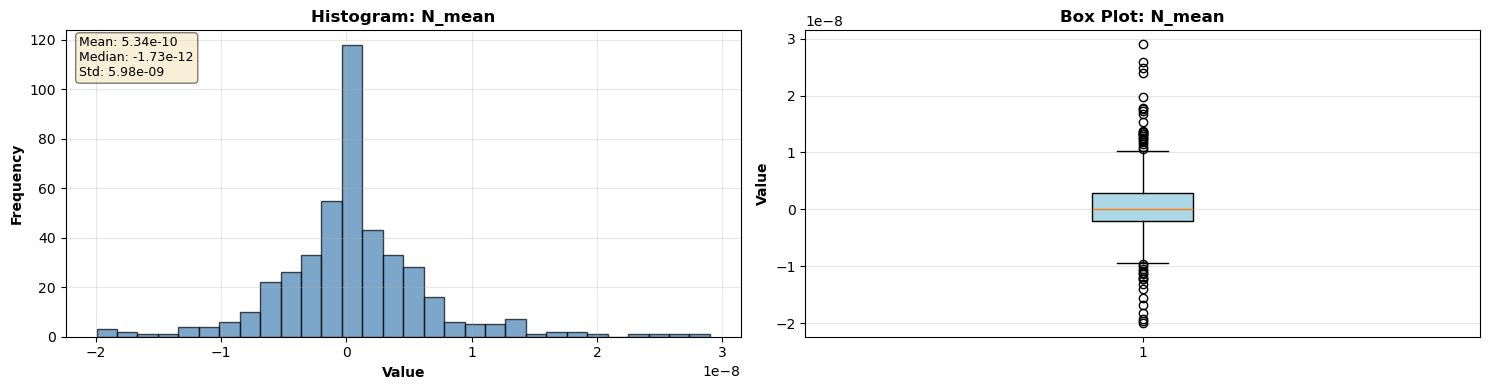

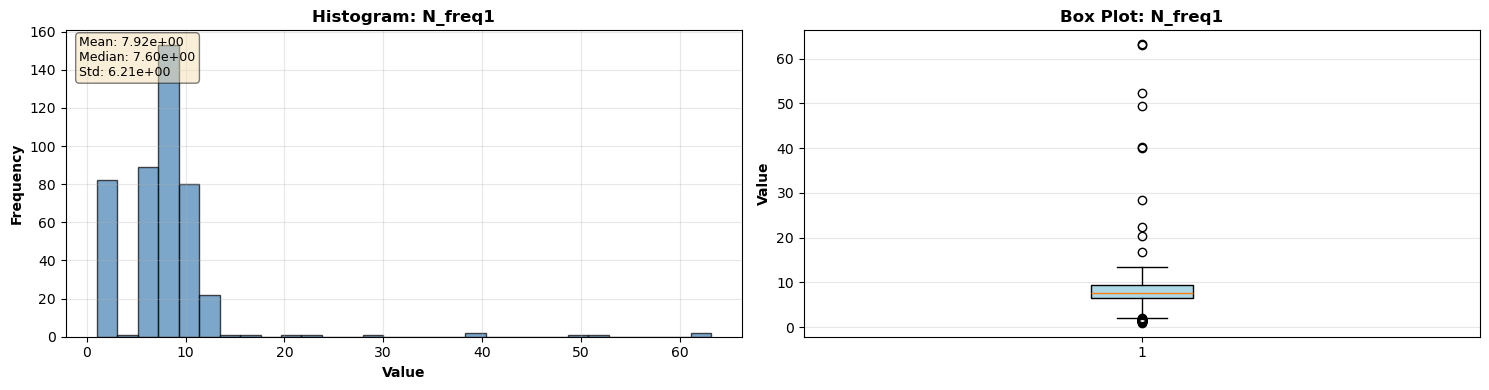

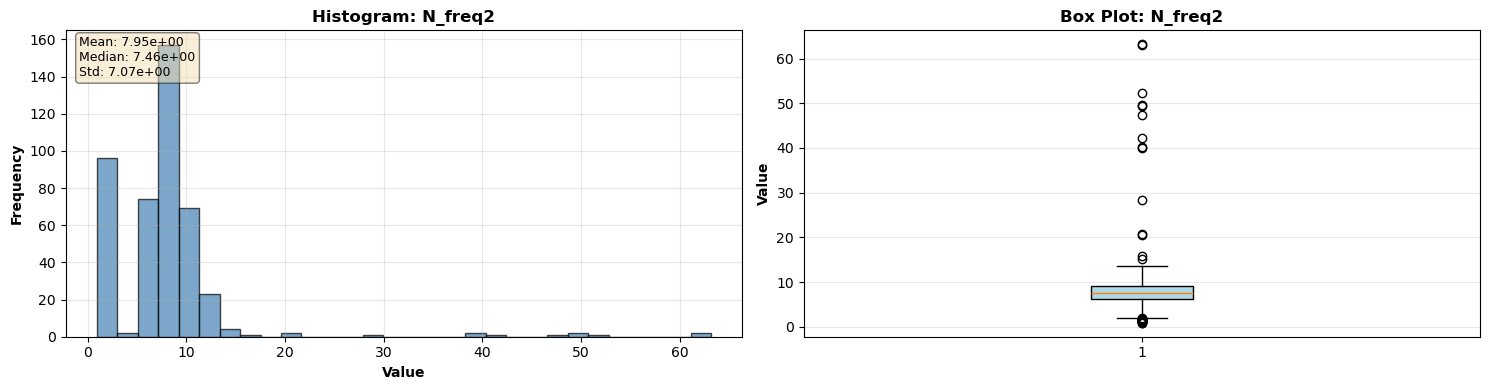

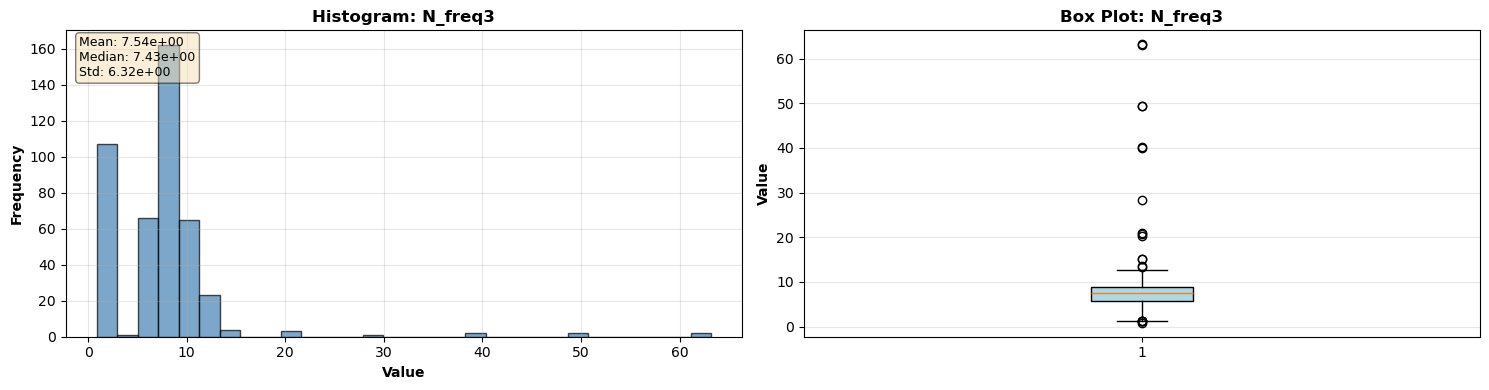

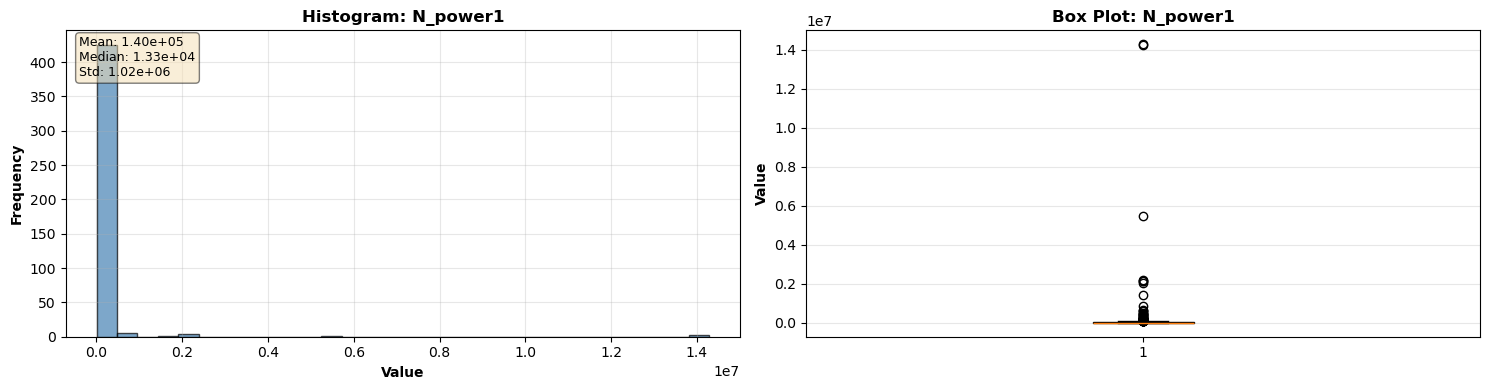

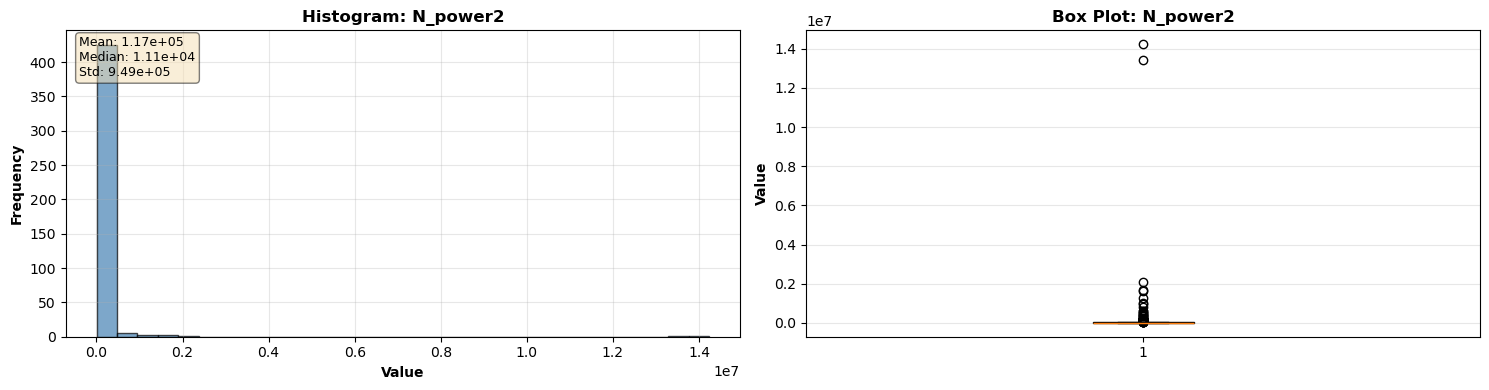

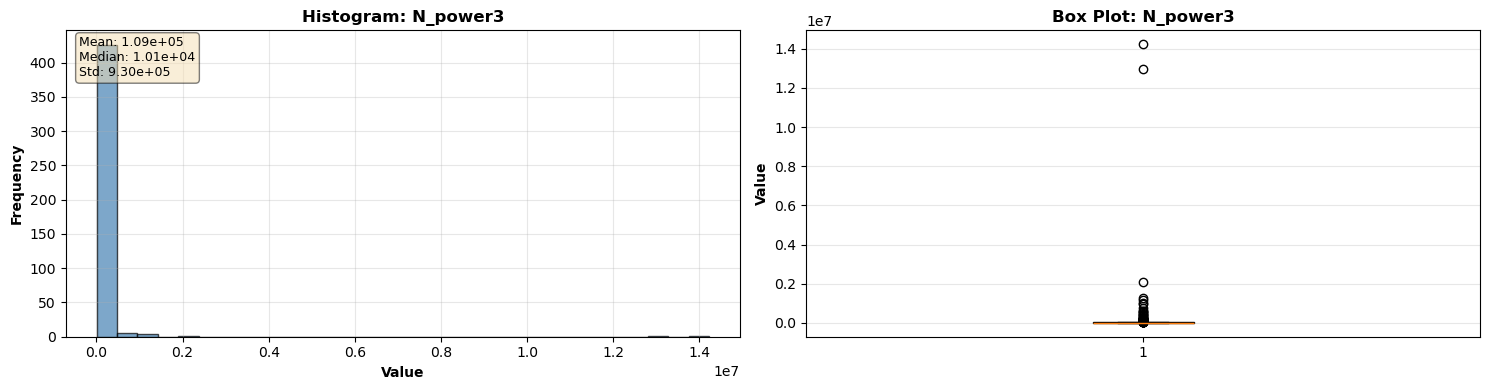

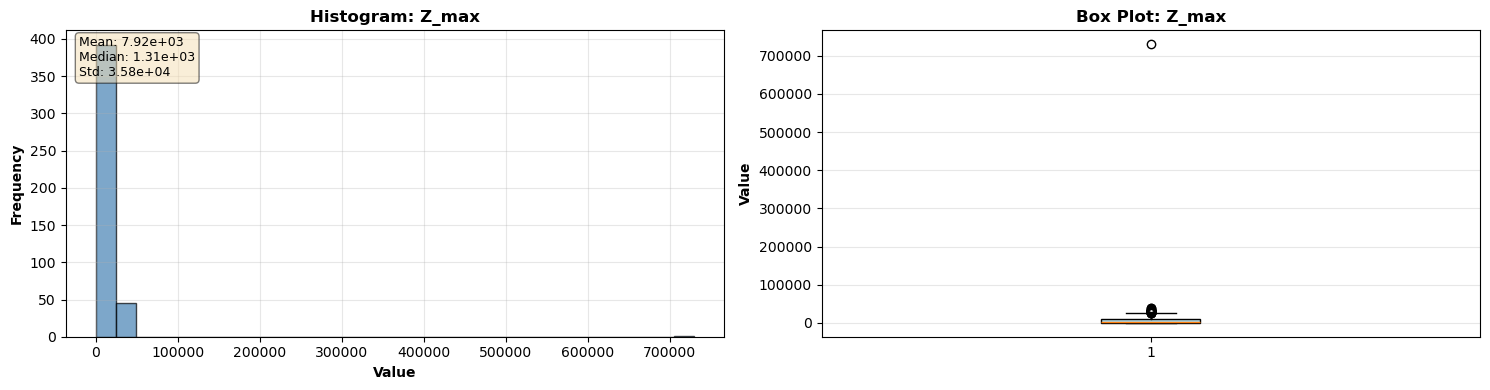

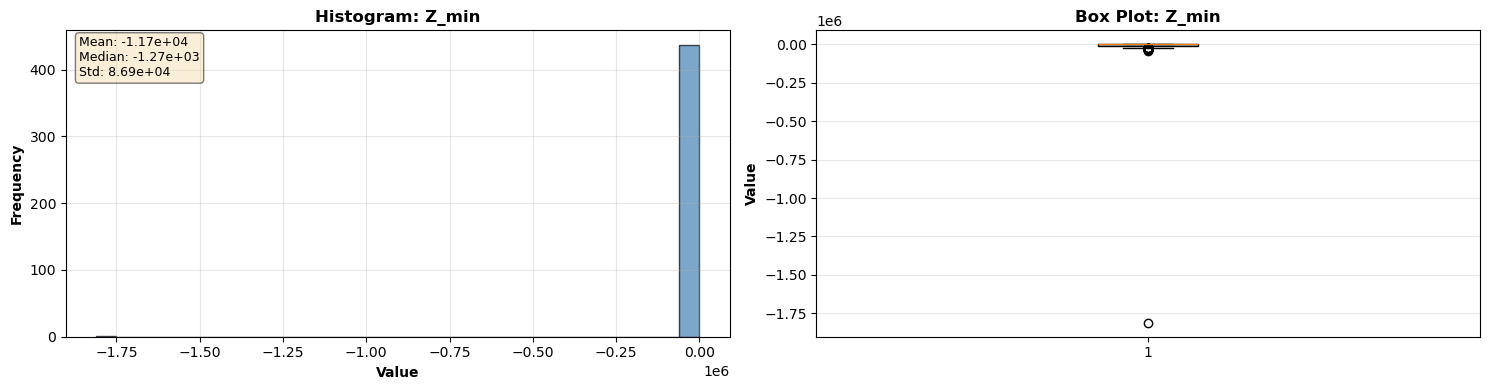

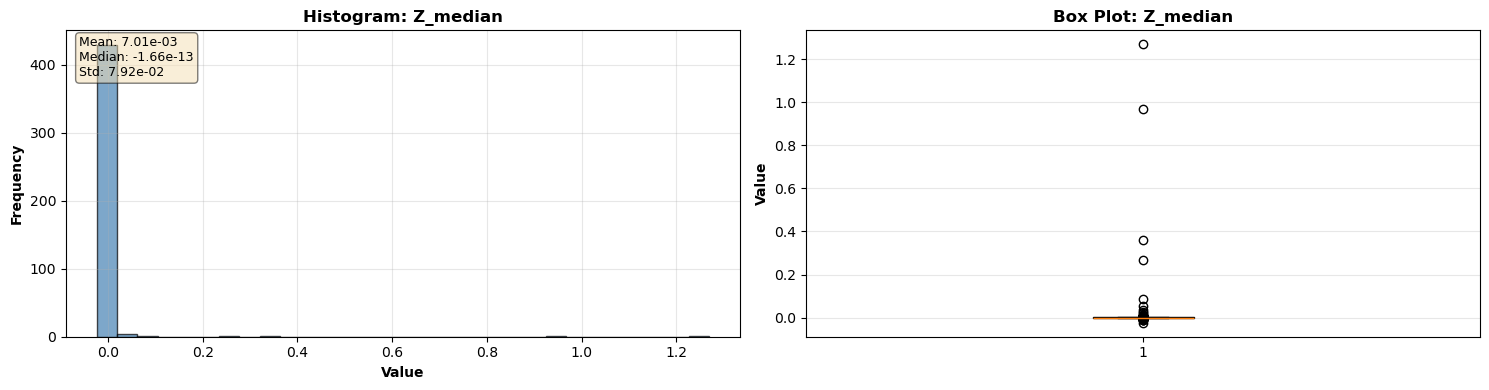

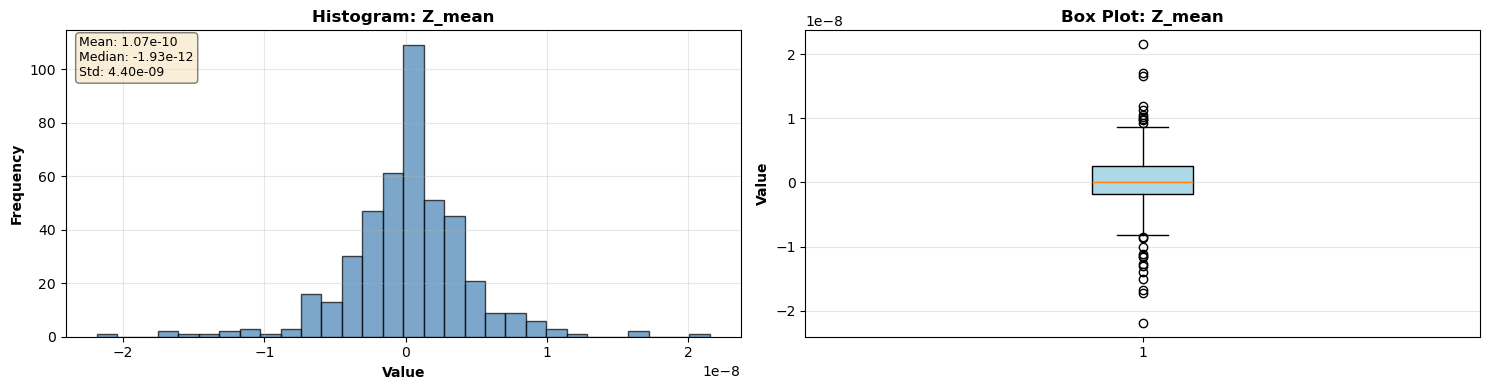

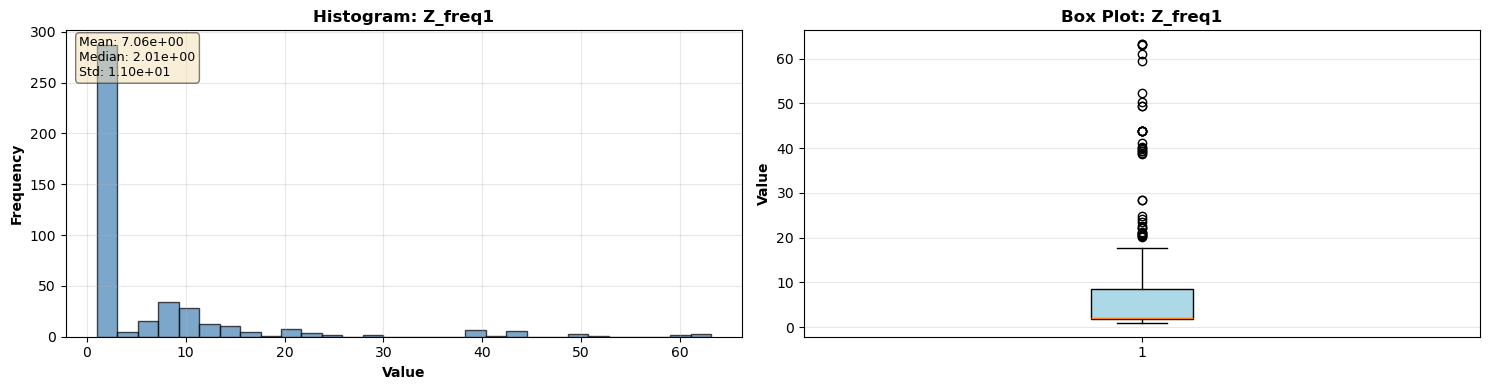

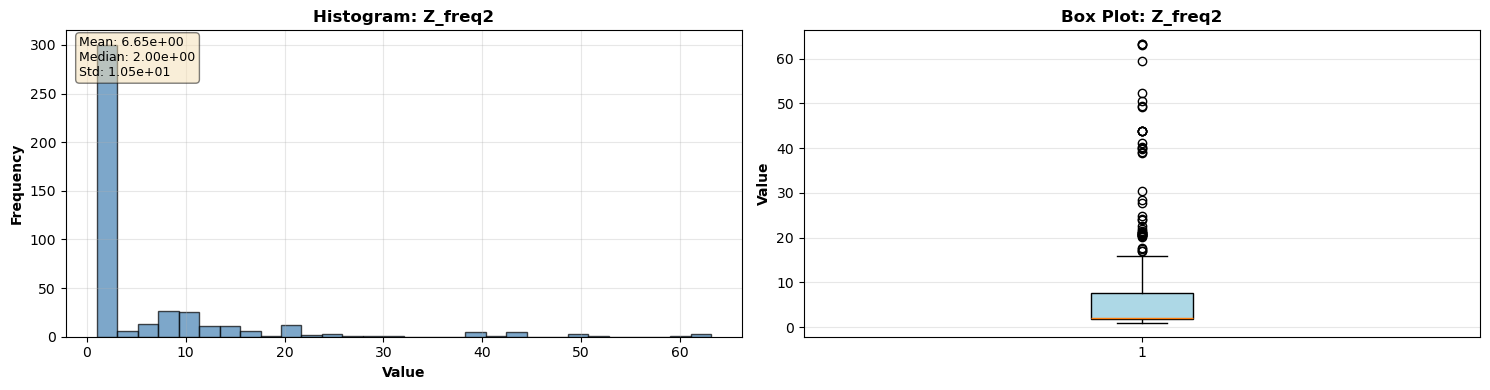

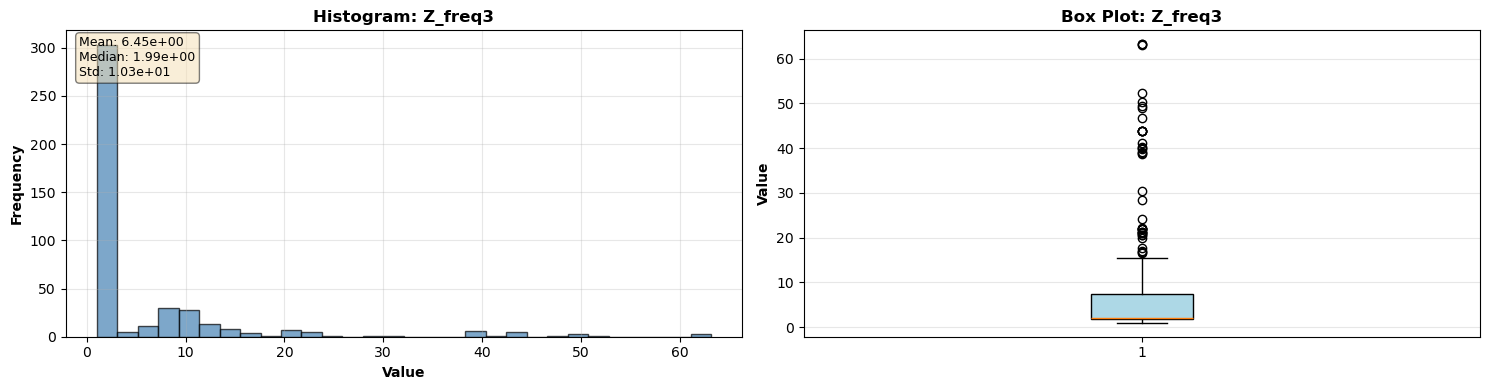

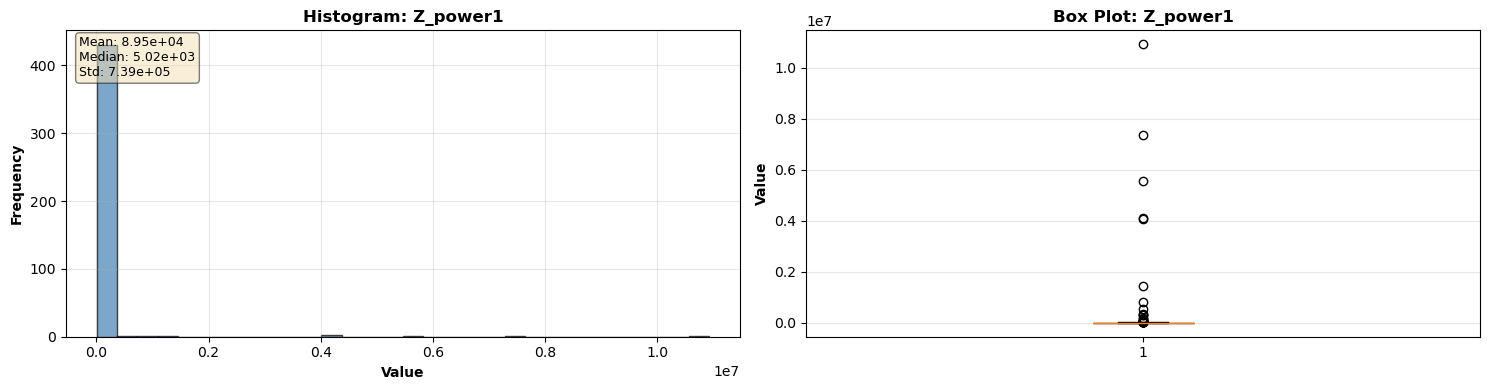

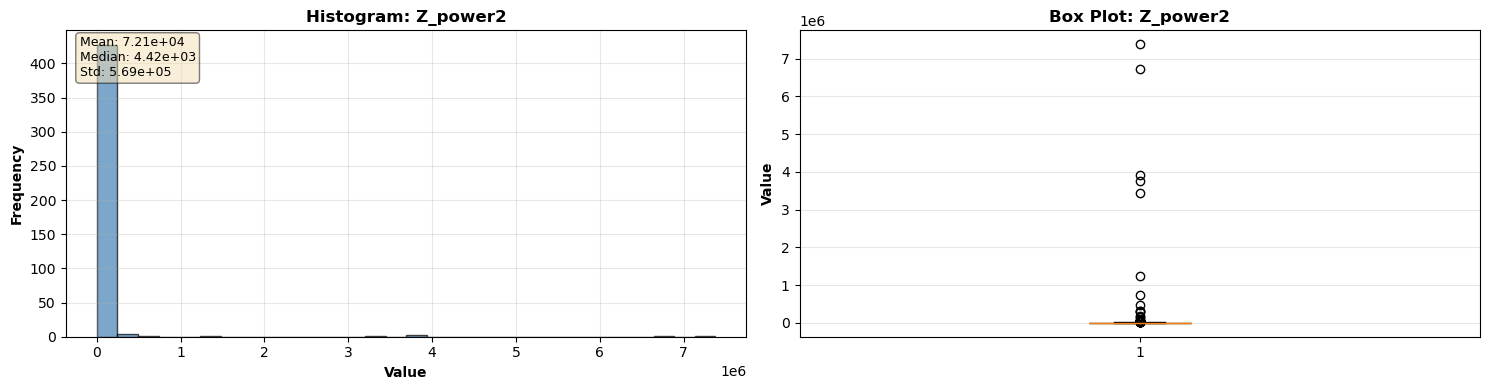

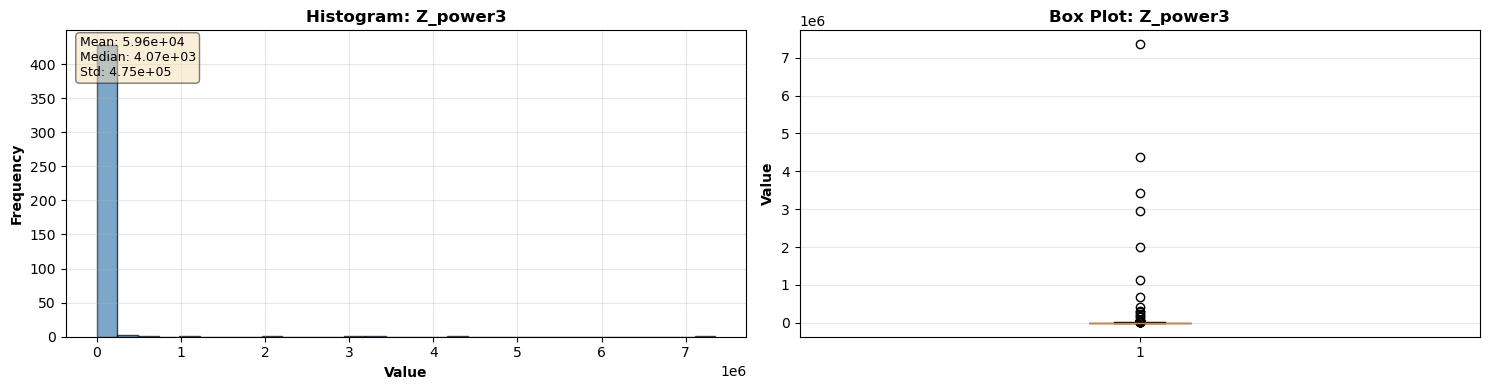


Plotting complete for 34 features.

Plotting Correlation Matrix


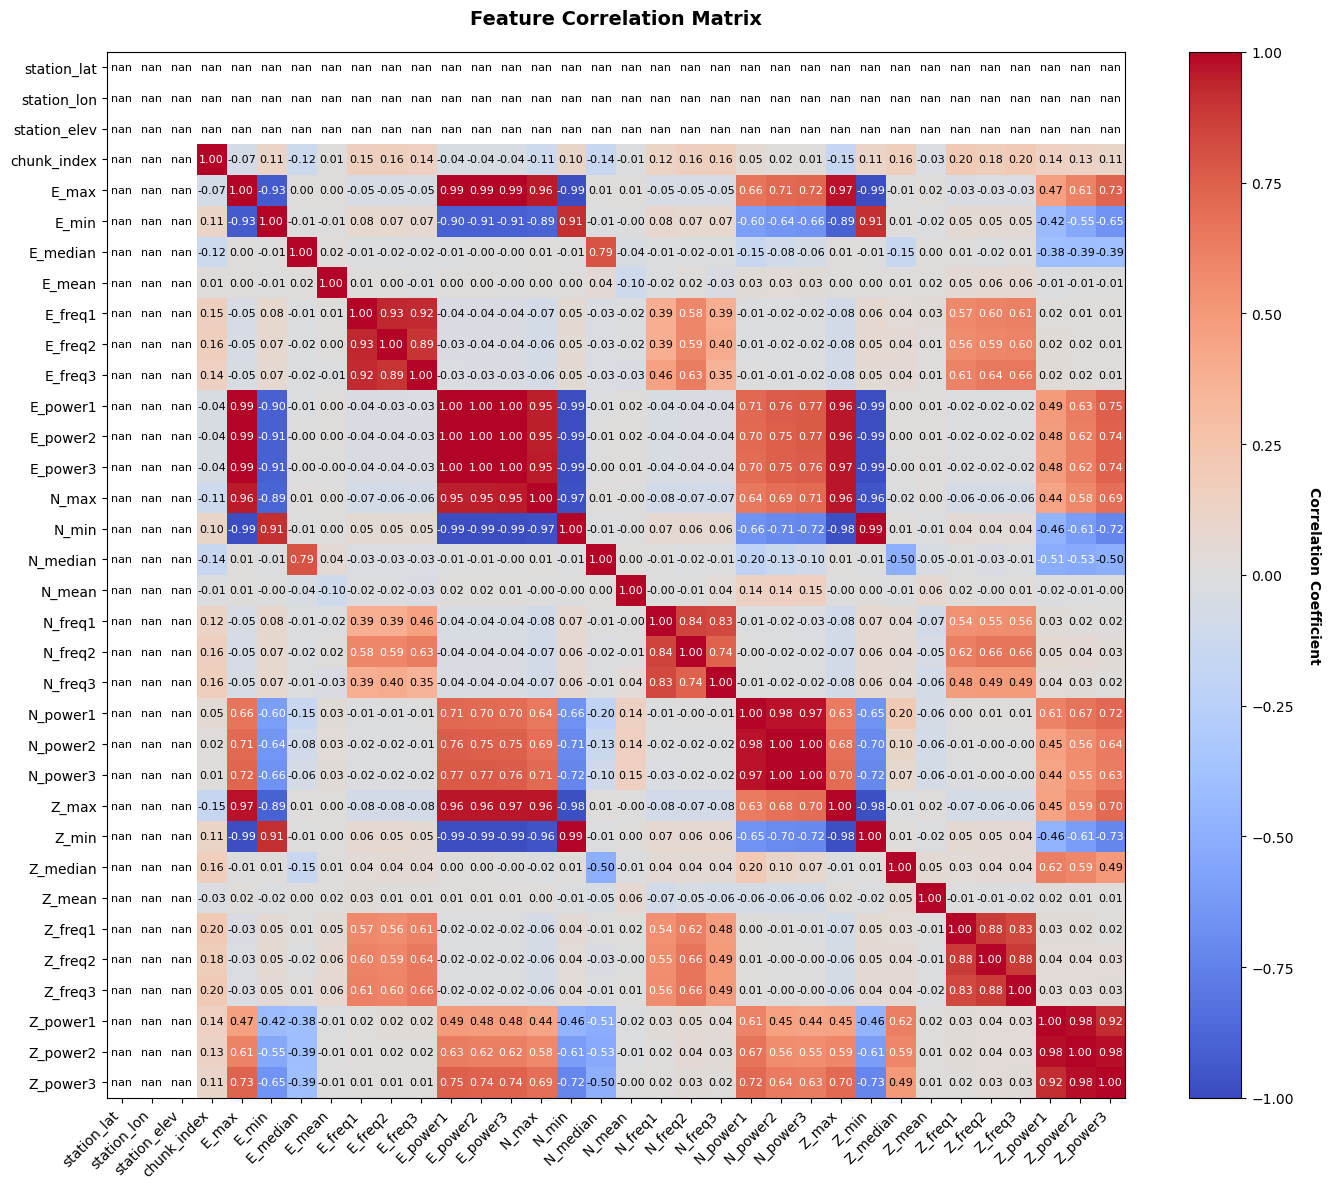


Correlation matrix computed for 34 numerical features.

Highly correlated feature pairs (|r| > 0.8):
  E_power2 <-> E_power3: 1.000
  E_power1 <-> E_power2: 1.000
  E_power1 <-> E_power3: 1.000
  N_power2 <-> N_power3: 0.999
  E_max <-> E_power3: 0.994
  E_max <-> E_power2: 0.993
  N_min <-> Z_min: 0.993
  E_max <-> E_power1: 0.993
  E_power3 <-> N_min: -0.991
  E_max <-> N_min: -0.991
  E_power2 <-> N_min: -0.990
  E_power3 <-> Z_min: -0.990
  E_power1 <-> N_min: -0.990
  E_power2 <-> Z_min: -0.989
  E_max <-> Z_min: -0.989
  E_power1 <-> Z_min: -0.989
  Z_power2 <-> Z_power3: 0.980
  N_min <-> Z_max: -0.979
  Z_power1 <-> Z_power2: 0.977
  Z_max <-> Z_min: -0.977
  N_power1 <-> N_power2: 0.976
  N_power1 <-> N_power3: 0.972
  E_max <-> Z_max: 0.971
  N_max <-> N_min: -0.971
  E_power3 <-> Z_max: 0.965
  E_power2 <-> Z_max: 0.965
  E_power1 <-> Z_max: 0.964
  N_max <-> Z_max: 0.962
  N_max <-> Z_min: -0.959
  E_max <-> N_max: 0.956
  E_power3 <-> N_max: 0.953
  E_power2 <-> N_max: 0.

In [16]:
# Process 365 days of seismic data starting from start_date
df_features = process_seismic_data_daily(
    client=client,
    network=network,
    station=station,
    location=location,
    channel=channel,
    start_date=start_date,
    num_days=365,
    chunk_hours=2
)

# Display basic information about the resulting dataframe
print("\nDataFrame Summary:")
print(f"Shape: {df_features.shape}")
print(f"\nFirst few rows:")
print(df_features.head())
print(f"\nColumn names:")
print(df_features.columns.tolist())

# Plot feature distributions
print("\n" + "="*60)
print("Plotting Feature Distributions")
print("="*60)
plot_feature_distributions(df_features, figsize=(15, 4), bins=30)

# Plot correlation matrix
print("\n" + "="*60)
print("Plotting Correlation Matrix")
print("="*60)
plot_correlation_matrix(df_features, figsize=(14, 12), cmap='coolwarm', annot=True, fmt='.2f')

Original shape: (438, 38)
Reduced shape: (438, 13)

Remaining columns:
['station_name', 'date', 'starttime', 'endtime', 'E_mean', 'E_freq1', 'E_power1', 'N_mean', 'N_freq1', 'N_power1', 'Z_mean', 'Z_freq1', 'Z_power1']

Plotting Correlation Matrix (Reduced Features)


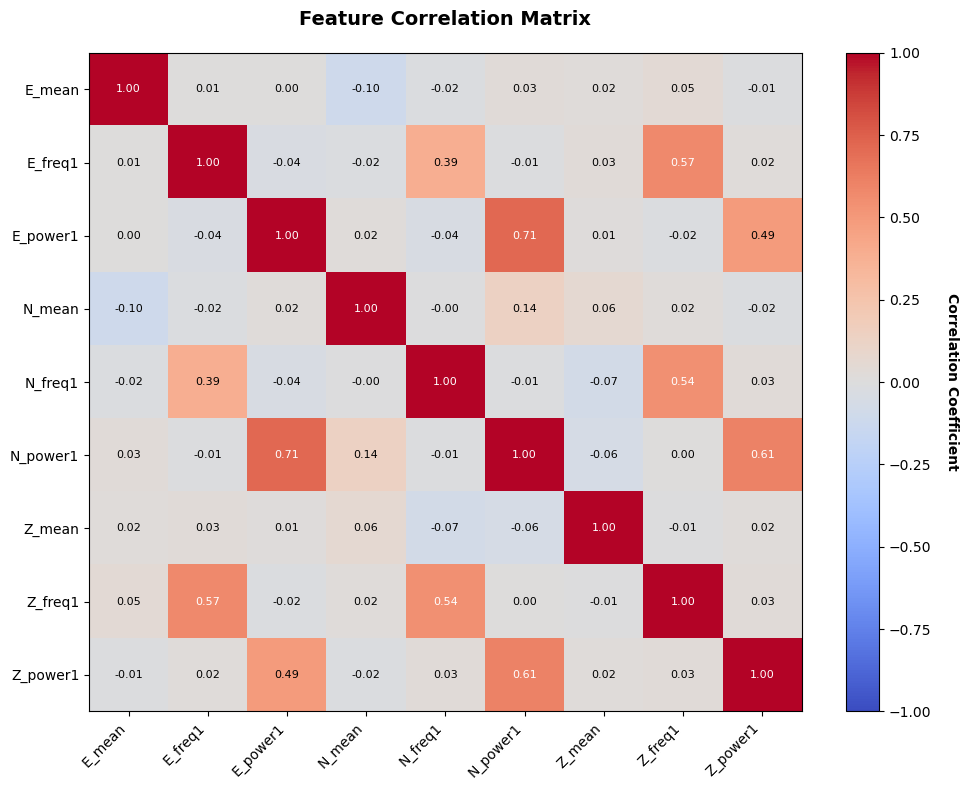


Correlation matrix computed for 9 numerical features.

Highly correlated feature pairs (|r| > 0.8):
  None found


In [23]:
# Drop the specified columns (2nd and 3rd powers and frequencies, plus min, median, and max)
columns_to_drop = [
    'E_freq2', 'E_freq3', 'E_power2', 'E_power3', 'E_min', 'E_median', 'E_max',
    'N_freq2', 'N_freq3', 'N_power2', 'N_power3', 'N_min', 'N_median', 'N_max',
    'Z_freq2', 'Z_freq3', 'Z_power2', 'Z_power3', 'Z_min', 'Z_median', 'Z_max',
    'station_lat', 'station_lon', 'station_elev', 'chunk_index'
]

# Create a new dataframe with the dropped columns
df_features_reduced = df_features.drop(columns=columns_to_drop)

print(f"Original shape: {df_features.shape}")
print(f"Reduced shape: {df_features_reduced.shape}")
print(f"\nRemaining columns:")
print(df_features_reduced.columns.tolist())

# Standardize the data before PCA
scaler = StandardScaler()
numerical_cols = df_features_reduced.select_dtypes(include=[np.number]).columns.tolist()
X_scaled = scaler.fit_transform(df_features_reduced[numerical_cols])

# Re-plot the correlation matrix with the reduced feature set
print("\n" + "="*60)
print("Plotting Correlation Matrix (Reduced Features)")
print("="*60)
plot_correlation_matrix(df_features_reduced, figsize=(10, 8), cmap='coolwarm', annot=True, fmt='.2f')

Performing PCA on 9 numerical features...
Features: ['E_mean', 'E_freq1', 'E_power1', 'N_mean', 'N_freq1', 'N_power1', 'Z_mean', 'Z_freq1', 'Z_power1']

Data standardized (mean=0, std=1)

PCA computed with 9 components
Total variance explained: 1.0000

Variance explained by each component:
  PC1: 0.2464 (0.2464 cumulative)
  PC2: 0.2231 (0.4695 cumulative)
  PC3: 0.1235 (0.5930 cumulative)
  PC4: 0.1144 (0.7074 cumulative)
  PC5: 0.0998 (0.8071 cumulative)


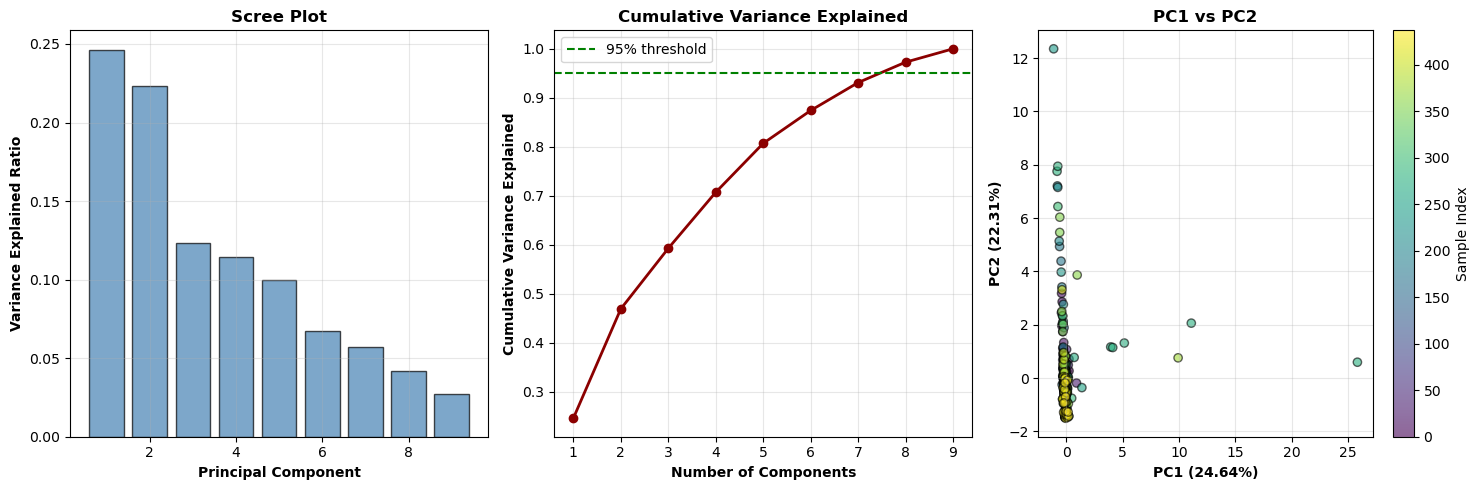

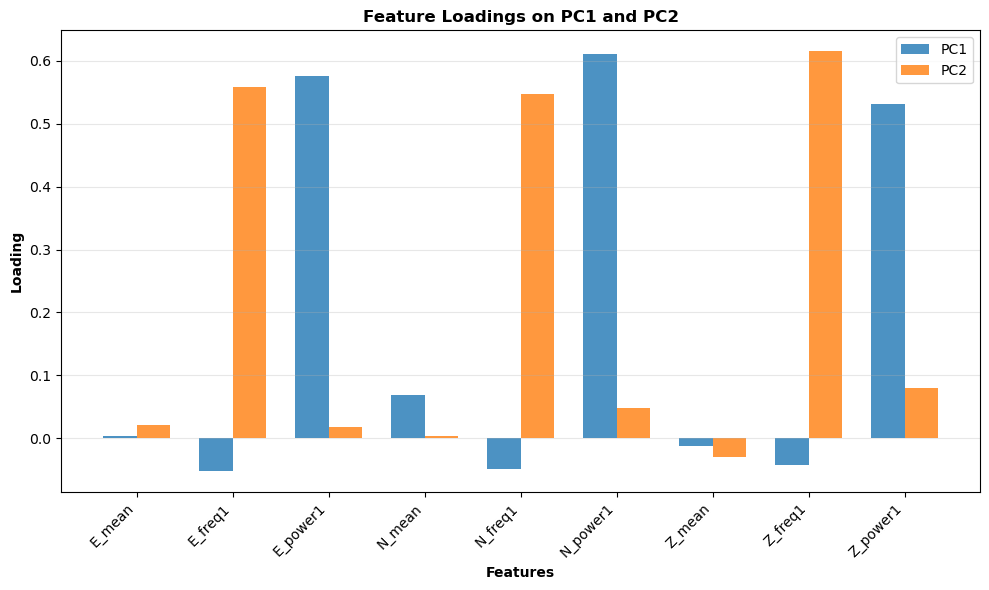

{'pca_model': PCA(n_components=9),
 'transformed_data':           PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
 0    0.241664  0.272252  0.714415  0.528561  0.955205  0.026850  0.040161   
 1    0.041979  0.253114 -0.624714  0.489442 -0.042468  0.062809 -0.152883   
 2   -0.198863  0.220133 -0.406701  0.108710 -0.786435  0.042378 -0.183425   
 3   -0.103423  0.223355  0.622436  0.687315  0.411993  0.094175 -0.008886   
 4   -0.095569 -0.148142  0.933702 -0.724437  0.436394 -0.116790  0.111489   
 ..        ...       ...       ...       ...       ...       ...       ...   
 433 -0.114563 -0.177415  0.307706 -0.417628  0.530324 -0.073775  0.084002   
 434 -0.067689 -0.696015  0.370420  0.126739  0.356305 -0.617643  0.142536   
 435 -0.014249 -1.238897 -0.195567  0.228537  0.511211 -0.157237  0.035804   
 436  0.162965 -1.270990  0.377801  0.465984  0.183173 -0.116843 -0.173983   
 437 -0.228132 -0.934588 -1.405034  1.972735 -0.898070  0.759746 -0.302216   
 
       

In [24]:
perform_pca_analysis(df_features_reduced, n_components=9, scale_data=True, plot_results=True, figsize=(15, 5))

In [25]:
df_features_reduced.to_csv('seismic_features_reduced_2018.csv', index=False)

In [26]:
df_features.to_csv('seismic_features_full_2018.csv', index=False)